In [1]:
%matplotlib notebook

/opt/sagemath-9.3/local/lib/python3.7/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/sagemath-9.3/local/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors
import inspect
import time
import pickle
import types
from matplotlib.patches import Wedge
import scipy.linalg
import matplotlib.cm as cm

### Define class to methods for things we might want to calculate

In [3]:
class TeichmullerPoly:
    def __init__(self,a,b):
        self.a = a
        self.b = b
        
    def is_prim(self):
        try:
            return self._is_prim
        except:
            self._is_prim = (gcd(self.a,self.b) == 1)
            return self._is_prim
        
    def poly(self):
        try:
            return self._poly
        except:
            R.<t> = PolynomialRing(QQbar)
            if self.a >= 0:
                self._poly = t^self.a-t^(4*self.a+self.b)-t^(self.b+3*self.a)-t^(self.b+2*self.a)-t^(self.b+self.a)-t^(self.b)+t^(2*self.b+3*self.a)
            else:
                self._poly = t^(-3*self.a)-t^self.b-t^(self.b-self.a)-t^(self.b-2*self.a)-t^(self.b-3*self.a)-t^(self.b-4*self.a)+t^(2*self.b-self.a)
            return self._poly  
        
    def poly_factors(self):
        try:
            return self._poly_factors
        except:
            R.<tt> = PolynomialRing(QQ)
            if self.a >= 0:
                poly = tt^self.a-tt^(4*self.a+self.b)-tt^(self.b+3*self.a)-tt^(self.b+2*self.a)-tt^(self.b+self.a)-tt^(self.b)+tt^(2*self.b+3*self.a)
            else:
                poly = tt^(-3*self.a)-tt^self.b-tt^(self.b-self.a)-tt^(self.b-2*self.a)-tt^(self.b-3*self.a)-tt^(self.b-4*self.a)+tt^(2*self.b-self.a)
            self._poly_factors = poly.factor()
            return self._poly_factors
    
    def roots(self):
        try:
            return self._roots
        except:
            self._roots = [r for r,m in self.poly().roots()]
            return self._roots
        
    def off_roots(self):
        try: 
            return self._off_roots
        except:
            off_roots = []
            for root in self.poly().complex_roots():
                if not (root.imag()==0 or np.abs(root.abs()-1)<10**-12):
                    off_roots.append(root)
            self._off_roots = off_roots
            return self._off_roots
        
    def num_off_roots(self):
        return len(self.off_roots())/4
        
    def dil(self):
        try:
            return self._dil
        except:
            roots = self.roots()
            self._dil = roots[np.argmax([num.abs().real_number(RR) for num in roots])]
            return self._dil
    
    def dil_minpoly(self):
        try:
            return self._dil_minpoly
        except:
            self._dil_minpoly = self.dil().minpoly()
            return self._dil_minpoly
        
    def dil_minpoly_degree(self):
        try:
            return self._dil_minpoly_degree
        except:
            self._dil_minpoly_degree = self.dil_minpoly().degree()
            return self._dil_minpoly_degree
    
    def dil_minpoly_roots(self):
        try:
            return self._dil_minpoly_roots
        except:
            self._dil_minpoly_roots = self.dil_minpoly().complex_roots()
            return self._dil_minpoly_roots
    
    def trace(self):
        try:
            return self._trace
        except:
            dil = self.dil()
            self._trace = dil + dil.inverse_of_unit()
            return self._trace
    
    def trace_minpoly(self):
        try:
            return self._trace_minpoly
        except:
            self._trace_minpoly = self.trace().minpoly()
            return self._trace_minpoly
    
    def trace_minpoly_roots(self):
        try:
            return self._trace_minpoly_roots
        except:
            self._trace_minpoly_roots = [r for r in self.trace_minpoly().complex_roots()]
            return self._trace_minpoly_roots
    
    def has_tot_real_trace_field(self):
        try:
            return self._has_tot_real_trace_field
        except:
            for root in self.trace_minpoly_roots():
                if not root.is_real():
                    self._has_tot_real_trace_field = False
                    return self._has_tot_real_trace_field
            self._has_tot_real_trace_field = True
            return self._has_tot_real_trace_field
        
    def degree_of_trace_field(self):
        try:
            return self._degree_of_trace_field
        except: 
            min_poly = self.trace_minpoly()
            self._degree_of_trace_field = min_poly.degree()
            return self._degree_of_trace_field
    
    def is_Salem(self,supress_output=True,tol = 10**-12):
        '''
        Takes a dilatation of a pseudo-Anosov homeomorphism.
        Returns True or False depending on if the dilatation is a Salem number.
        A Salem number is an algebraic unit where all of its Galois conjugates (besides possibly its inverse) lie on the unit circle in CC.
        '''
        try:
            return self._is_Salem
        except:
            dil = self.dil()
            for root in self.dil_minpoly_roots():
                if not ((root.abs() - 1)<tol or (root-dil).abs()<tol or (root - dil.inverse_of_unit()).abs()<tol):
                    if not supress_output: print("Root", root, "does not lie on the unit circle.")
                    self._is_Salem = False
                    return self._is_Salem

            #otherwise, dil is a Salem number
            self._is_Salem = True
            return self._is_Salem
        
    def is_biPerron(self,supress_output=True):
        '''
        Takes a dilatation of a pseudo-Anosov homeomorphism.
        Returns True or False depending on if the dilatation is a bi-Perron number.
        A bi-Perron number is an algebraic unit where all of its Galois conjugates (besides possibly its inverse) lie in the interval (1/dil,dil) in CC.
        '''
        
        try:
            return self._is_biPerron
        except:
            dil = self.dil()

            inv = dil.inverse_of_unit().complex_exact(CC) #convert to ComplexNumber for comparison with roots of min poly
            dilc = dil.complex_exact(CC)

            #check if roots of min poly lie between dil and inv
            roots = self.dil_minpoly_roots()
            for root in roots:
                if not (inv < root.abs() < dilc or root == inv or root == dilc):
                    if not supress_output: print("Root", root, "does not lie between dil", dil, "and its inverse", inv)
                    self._is_biPerron = False
                    return self._is_biPerron

            #otherwise, dil is a biPerron number
            self._is_biPerron = True
            return self._is_biPerron
        
    def plot_dil_minpoly_roots(self, lim=1.5):
        fig, ax = plt.subplots(figsize = (7,7))

        ax.set_xlim(-lim,lim)
        ax.set_ylim(-lim,lim)

        circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
        circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
        ax.plot(circ_x,circ_y,alpha=0.5,c='grey')
        ax.plot([-lim,lim],[0,0],color='k')
        ax.plot([0,0],[-lim,lim],color='k')

        roots = self.dil_minpoly_roots()
        reals = [root.real_part() for root in roots]
        imags = [root.imag_part() for root in roots]
        ax.scatter(reals, imags, s=50)
        plt.title(f"Roots of minimal polynomial of dilatation for ({self.a},{self.b})")
        plt.show()
        
    def dil_minpoly_mahler_measure(self):
        try:
            return self._dil_minpoly_mahler_measure
        except:
            measure = 1
            for root in self.dil_minpoly_roots():
                modulus = root.abs()
                if modulus > 1:
                    measure *= modulus
            self._dil_minpoly_mahler_measure = measure
            return self._dil_minpoly_mahler_measure
        
    def trace_minpoly_mahler_measure(self):
        try:
            return self._trace_minpoly_mahler_measure
        except:
            measure = 1
            for root in self.trace_minpoly_roots():
                modulus = root.abs()
                if modulus > 1:
                    measure *= modulus
            self._trace_minpoly_mahler_measure = measure
            return self._trace_minpoly_mahler_measure

In [4]:
#function which return existing class or creates new one and caches it
def teich_poly(a,b):
    try:
        return tp_cache[f"{a},{b}"]
    except:
        tp_cache[f"{a},{b}"] = TeichmullerPoly(a,b)
        return tp_cache[f"{a},{b}"]

### How to update class

#how to add a new method to every instance of the class in our cache

def trace_minpoly_mahler_measure(self):
    try:
        return self._trace_minpoly_mahler_measure
    except:
        measure = 1
        for root in self.trace_minpoly_roots():
            modulus = root.abs()
            if modulus > 1:
                measure *= modulus
        self._trace_minpoly_mahler_measure = measure
        return self._trace_minpoly_mahler_measure
    
for key in tp_cache.keys():
    tp = tp_cache[key]
    tp.trace_minpoly_mahler_measure = types.MethodType(trace_minpoly_mahler_measure, tp)
    
print("Done!")

#how to delete cached values so they can be recomputed:
for tp in tp_cache.values():
    try:
        del tp._dil_minpoly_roots
    except:
        pass

### Generate Teichmuller polynomial and calculate information of interest for cone with $1 \leq b \leq 50$. Pickle for easy access later.

In [68]:
#WARNING: Running this will empty the cache!!
tp_cache = {}
for b in range(1,50):
    for a in range(-((b-1)//3),b):
        tp_cache[f'{a},{b}'] = TeichmullerPoly(a,b)

In [74]:
#calculate values
skip_list = [
    '<bound method plot_dil_minpoly_roots of <__main__.TeichmullerPoly object at',
    '<bound method TeichmullerPoly.plot_dil_minpoly_roots of <__main__.TeichmullerPoly object at'
]

for tp in tqdm(tp_cache.values()):
    attrs = (getattr(tp, name) for name in dir(tp))
    methods = filter(inspect.ismethod, attrs)
    for phrase in skip_list:
        methods = filter(lambda x: str(x)[:len(phrase)] != phrase, methods)
    for method in methods:
        try:
            method()
        except TypeError:
            # Can't handle methods with required arguments.
            pass

  0%|          | 0/1601 [00:00<?, ?it/s]

In [75]:
#save cache
with open('dil_data_mcmullen.pkl', 'wb') as f:
    pickle.dump(tp_cache, f)

### Load in previously calculated information

In [5]:
%%time
tp_cache = {}
with open('dil_data_mcmullen.pkl', 'rb') as f:
    tp_cache = pickle.load(f)

CPU times: user 3min 55s, sys: 2.09 s, total: 3min 57s
Wall time: 3min 57s


### Set-up

In [6]:
all_points = []
prim_points = []

for b in range(1,50):
    for a in range(-((b-1)//3),b):
        all_points.append((a,b))
        if math.gcd(a,b) == 1:
            prim_points.append((a,b))

In [7]:
def plot_boundary(stop, ax):
    ax.plot([0,stop],[0,stop],'--',c='k')
    ax.plot([0,-stop//3],[0,stop],'--',c='k')
    return

### Display primitive elements

<IPython.core.display.Javascript object>


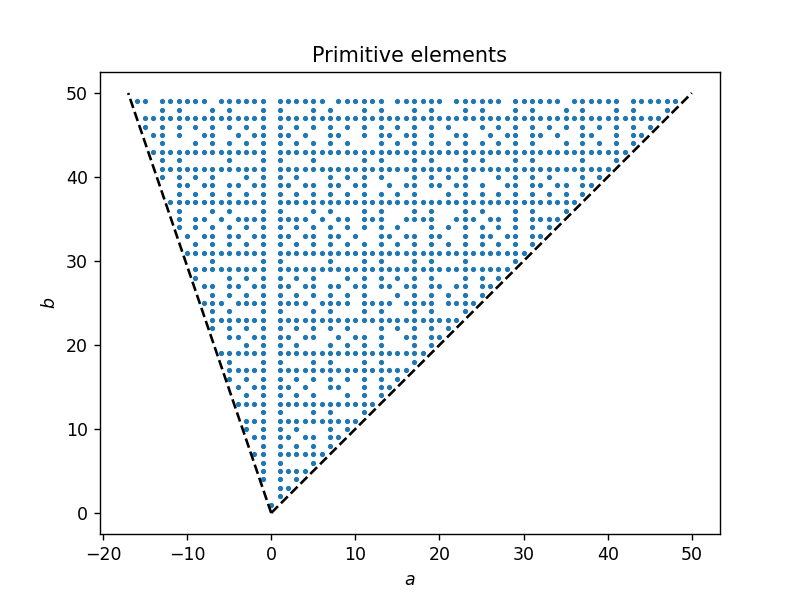

In [8]:
stop = 50

x=[]
y=[]

for a,b in prim_points:
    if b <= stop:
        x.append(a)
        y.append(b)

fig, ax = plt.subplots()
ax.scatter(x,y,s=10000/(stop**2))
plot_boundary(stop, ax)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')
ax.set_title('Primitive elements')
fig.show()

### Display if dilatations have totally real trace field

<IPython.core.display.Javascript object>


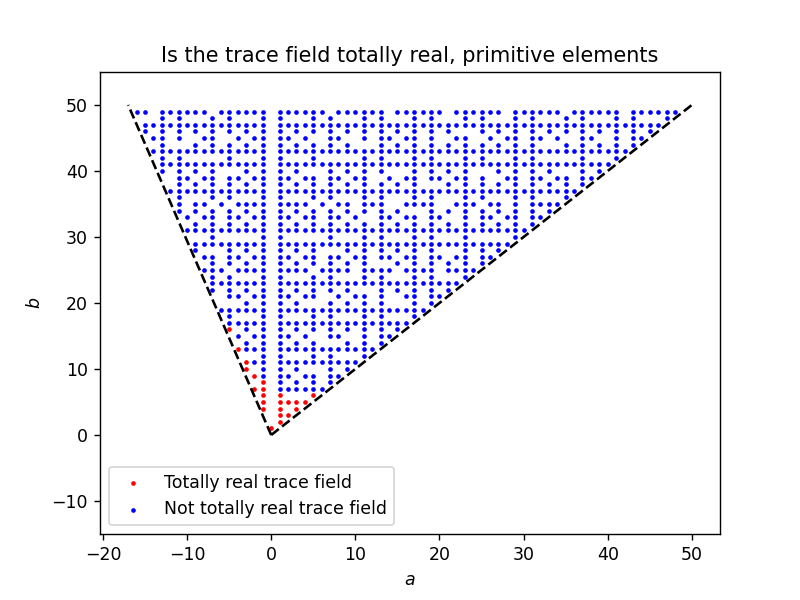

In [9]:
stop = 50

true_a = []
true_b = []
false_a = []
false_b = []

for a,b in all_points:
    if b <= stop:
        tp = teich_poly(a,b)
        if tp.is_prim():
            if tp.has_tot_real_trace_field() == True:
                true_a.append(a)
                true_b.append(b)
            else:
                false_a.append(a)
                false_b.append(b)

fig, ax = plt.subplots()

plot_boundary(stop, ax)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')
ax.scatter(true_a,true_b,label = "Totally real trace field", c = 'red', s=7000/(stop**2))
ax.scatter(false_a,false_b,label = "Not totally real trace field", c = 'blue', s=7000/(stop**2))
ax.set_ylim([-0.3*stop,stop*1.1])
ax.legend()
ax.set_title("Is the trace field totally real, primitive elements")

plt.show()         

<IPython.core.display.Javascript object>


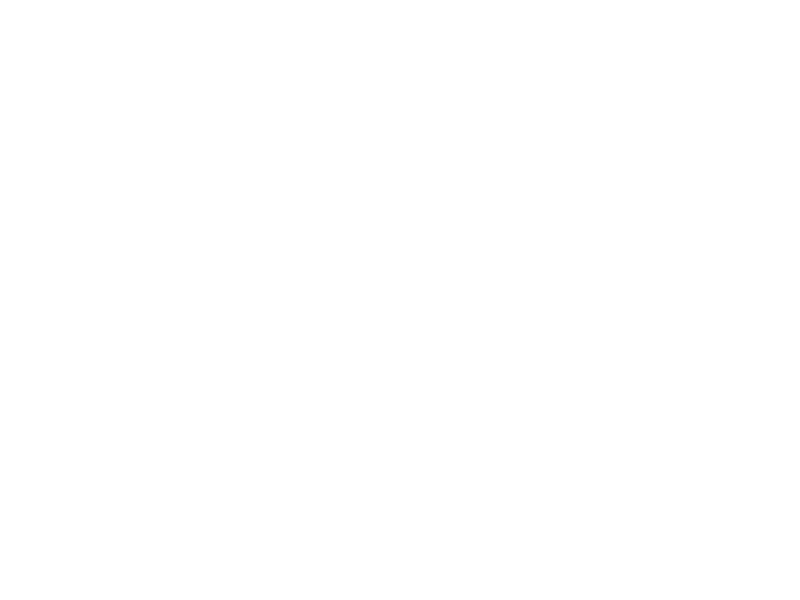

In [80]:
stop = 30

true_a = []
true_b = []
false_a = []
false_b = []

for a,b in all_points:
    if b <= stop:
        tp = teich_poly(a,b)
        if tp.has_tot_real_trace_field() == True:
            true_a.append(a)
            true_b.append(b)
        else:
            false_a.append(a)
            false_b.append(b)

fig, ax = plt.subplots()

plot_boundary(stop, ax)
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')
ax.scatter(true_a,true_b,label = "Totally real trace field", c = 'red', s=7000/(stop**2))
ax.scatter(false_a,false_b,label = "Not totally real trace field", c = 'blue', s=7000/(stop**2))
ax.set_ylim([-0.3*stop,stop*1.1])
ax.legend()
ax.set_title("Is the trace field totally real, all elements")

plt.show()         

### Plot degrees of minimal polynomials of dilatations

<IPython.core.display.Javascript object>


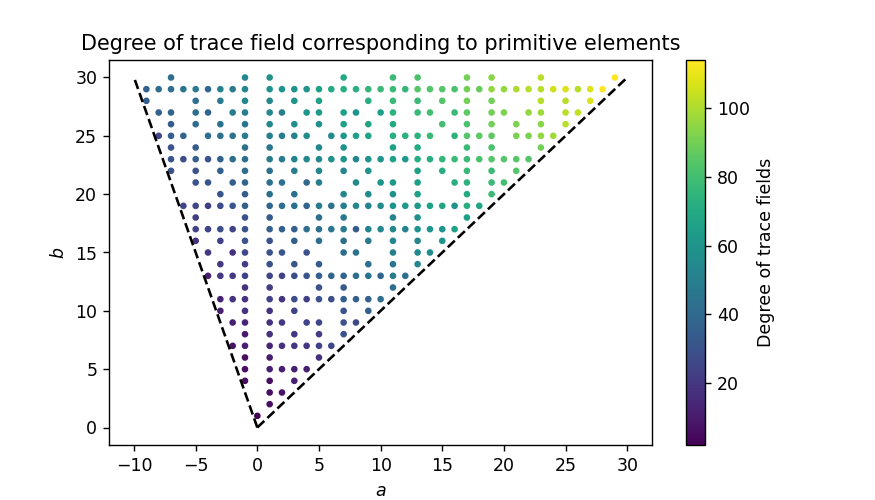

In [83]:
stop = 30

true_a = []
true_b = []
true_deg = []
false_a = []
false_b = []
false_deg = []

for a,b in all_points:
    if b <= stop:
        tp = teich_poly(a,b)
        if tp.is_prim():
            if tp.has_tot_real_trace_field() == True:
                true_a.append(a)
                true_b.append(b)
                true_deg.append(tp.dil_minpoly_degree())
            else:
                false_a.append(a)
                false_b.append(b)
                false_deg.append(tp.dil_minpoly_degree())

deg_min = min(true_deg + false_deg)
deg_max = max(true_deg + false_deg)

plt.close()

plt.figure(figsize=(7,4))
plt.scatter(true_a, true_b,c=true_deg, vmin=deg_min,vmax=deg_max, label = 'Totally real trace field', s=7000/(stop**2))
plt.scatter(false_a, false_b, c=false_deg, vmin=deg_min,vmax=deg_max, label = 'Not totally real trace field', s=7000/(stop**2))
plot_boundary(stop, plt)
plt.xlabel('$a$')
plt.ylabel('$b$')
#plt.ylim([-0.3*stop,stop*1.1])
plt.title('Degree of trace field corresponding to primitive elements')
#plt.legend()
cbar = plt.colorbar()
cbar.set_label('Degree of trace fields')
plt.show()

<IPython.core.display.Javascript object>


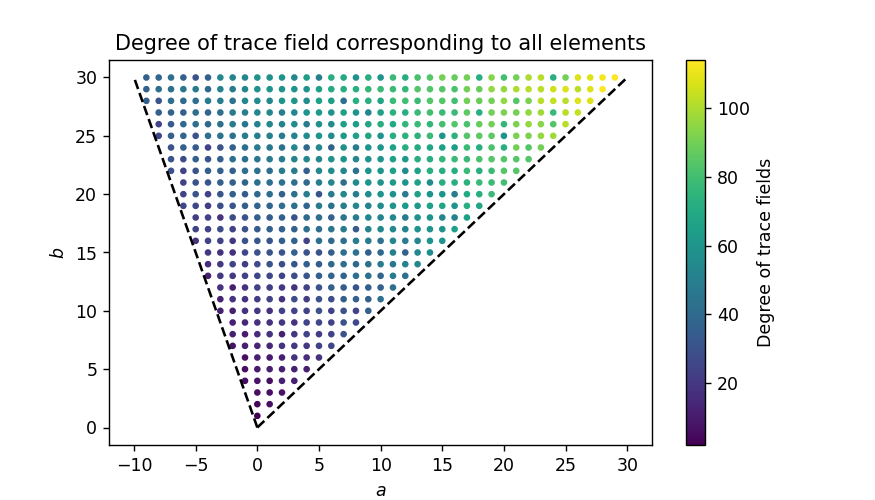

In [84]:
stop = 30

true_a = []
true_b = []
true_deg = []
false_a = []
false_b = []
false_deg = []

for a,b in all_points:
    if b <= stop:
        tp = teich_poly(a,b)
        if tp.has_tot_real_trace_field() == True:
            true_a.append(a)
            true_b.append(b)
            true_deg.append(tp.dil_minpoly_degree())
        else:
            false_a.append(a)
            false_b.append(b)
            false_deg.append(tp.dil_minpoly_degree())

deg_min = min(true_deg + false_deg)
deg_max = max(true_deg + false_deg)

plt.close()

plt.figure(figsize=(7,4))
plt.scatter(true_a, true_b,c=true_deg, vmin=deg_min,vmax=deg_max, label = 'Totally real trace field', s=7000/(stop**2))
plt.scatter(false_a, false_b, c=false_deg, vmin=deg_min,vmax=deg_max, label = 'Not totally real trace field', s=7000/(stop**2))
plot_boundary(stop, plt)
plt.xlabel('$a$')
plt.ylabel('$b$')
#plt.ylim([-0.3*stop,stop*1.1])
plt.title('Degree of trace field corresponding to all elements')
#plt.legend()
cbar = plt.colorbar()
cbar.set_label('Degree of trace fields')
plt.show()

### Plot whether dilatations are Salem

### Animation

<IPython.core.display.Javascript object>


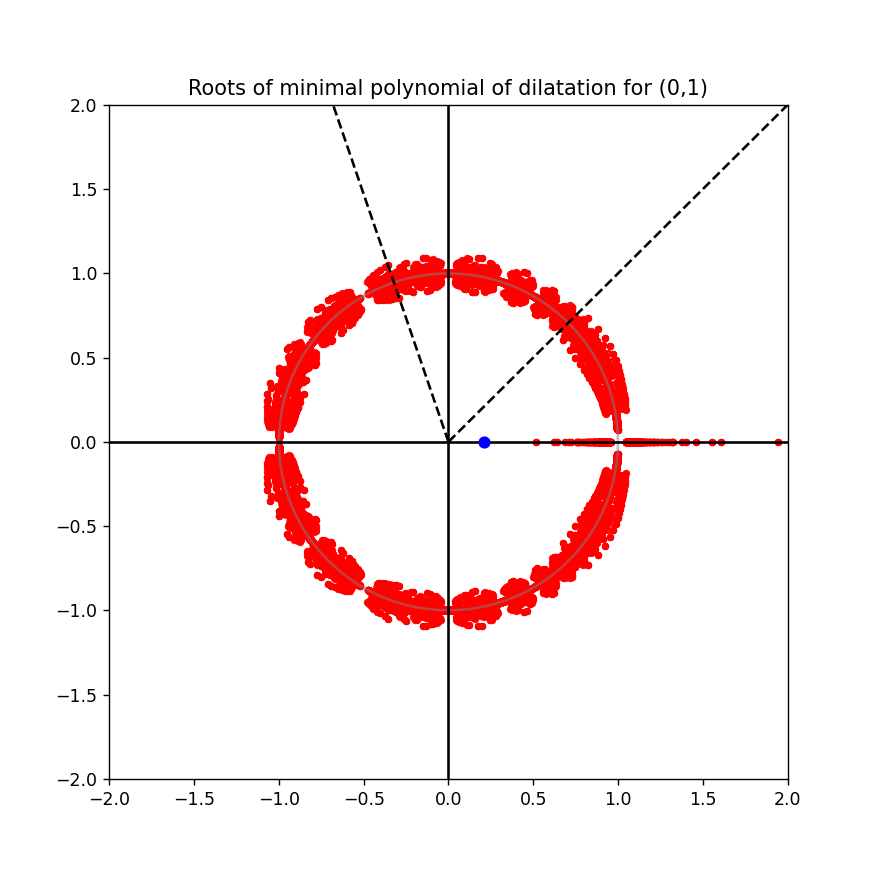

In [12]:
plt.close()

stop = 30 

pairs = []
for a,b in all_points:
    if b <= stop:
        if gcd(a,b) == 1:
            pairs.append((a,b))

fig, ax = plt.subplots(figsize = (7,7))

lim = 2
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)

circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
ax.plot(circ_x,circ_y,alpha=0.5,c='grey')
ax.plot([-lim,lim],[0,0],color='k')
ax.plot([0,0],[-lim,lim],color='k')

pointplot, = plt.plot([], [], 'o', c='blue')
def animate(i):
    a,b = pairs[i]
    tp = teich_poly(a,b)
    roots = tp.dil_minpoly_roots()
    reals = [root.real_part() for root in roots]
    imags = [root.imag_part() for root in roots]
    pointplot.set_data(reals, imags)
    ax.scatter(reals, imags, c='red', s=10, alpha=.25)
    plt.title(f"Roots of minimal polynomial of dilatation for ({a},{b})")
    return pointplot,

anim = FuncAnimation(fig, animate, frames=len(pairs), interval=10, repeat_delay=10**7)
plt.show()

<IPython.core.display.Javascript object>


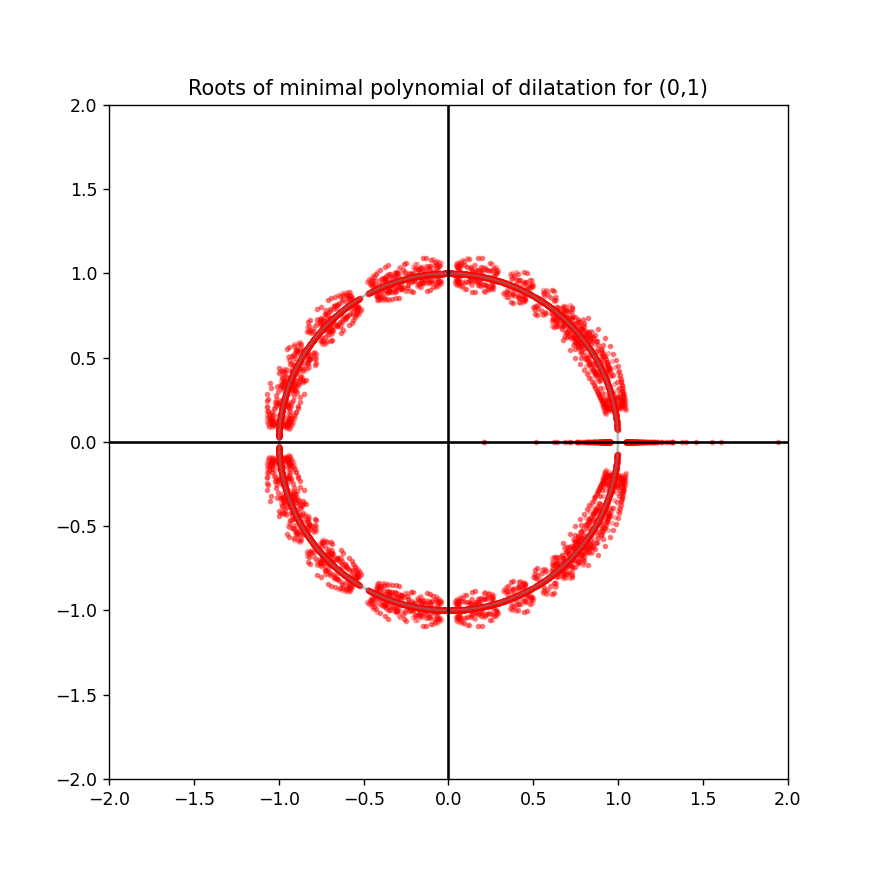

In [73]:
plt.close()

stop = 30

pairs = []
for a,b in all_points:
    if b <= stop:
        if gcd(a,b) == 1:
            pairs.append((a,b))

fig, ax = plt.subplots(figsize = (7,7))

lim = 2
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)

circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
ax.plot(circ_x,circ_y,alpha=0.5,c='grey')
ax.plot([-lim,lim],[0,0],color='k')
ax.plot([0,0],[-lim,lim],color='k')

#pointplot, = plt.plot([], [], 'o', c='red')
def animate(i):
    a,b = pairs[i]
    tp = teich_poly(a,b)
    roots = tp.dil_minpoly_roots()
    reals = [root.real_part() for root in roots]
    imags = [root.imag_part() for root in roots]
    pointplot.set_data(reals, imags)
    ax.scatter(reals, imags, c='red', s=5, alpha=.25)
    plt.title(f"Roots of minimal polynomial of dilatation for ({a},{b})")
    return pointplot,

anim = FuncAnimation(fig, animate, frames=len(pairs), interval=1, repeat_delay=10**7)
plt.show()

## Mahler measure

<IPython.core.display.Javascript object>


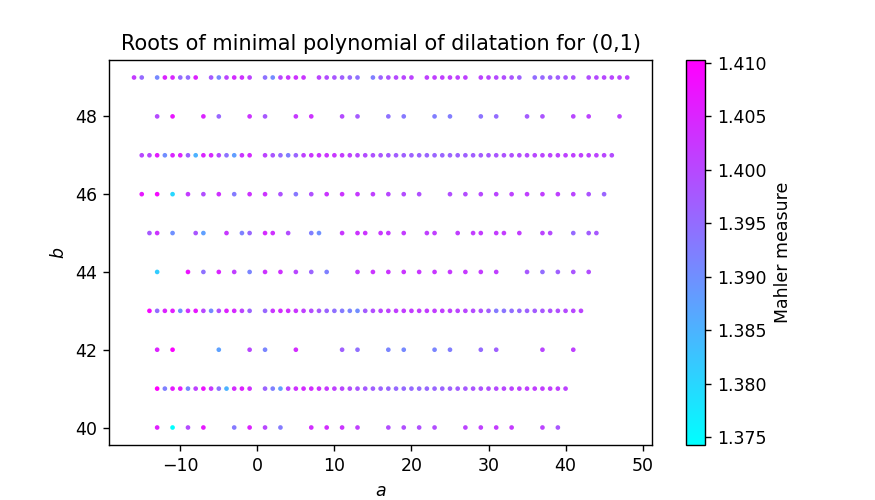

In [14]:
stop = 50

a_list = []
b_list = []
measures = []

for a,b in all_points:
    if 40 <= b <= stop:
        if gcd(a,b) == 1:
            tp = teich_poly(a,b)
            a_list.append(a)
            b_list.append(b)
            measures.append(tp.dil_minpoly_mahler_measure())

plt.figure(figsize=(7,4))
gamma = 0.4
cmap = cm.cool
norm = colors.PowerNorm(gamma,vmin=min(measures),vmax=max(measures))
plt.scatter(a_list, b_list,c=measures, cmap = cmap, s=7000/(stop**2))
#plt.scatter(a_list, b_list,c=measures, cmap = cmap, norm=norm, s=7000/(stop**2))
plot_boundary(stop, ax)
plt.xlabel('$a$')
plt.ylabel('$b$')
plt.title('Mahler measure of min poly for dilatation')
cbar = plt.colorbar()
cbar.set_label('Mahler measure')
plt.show()

<IPython.core.display.Javascript object>


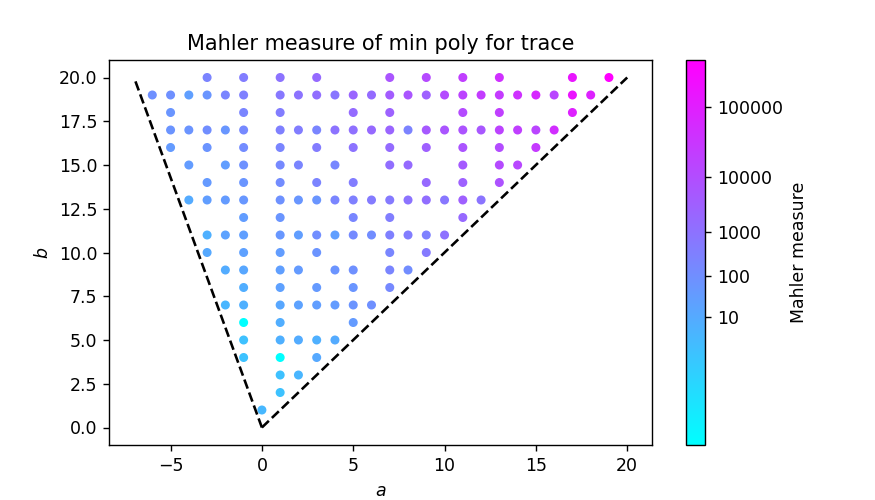

In [89]:
stop = 20

a_list = []
b_list = []
measures = []

for a,b in all_points:
    if b <= stop:
        if gcd(a,b) == 1:
            tp = teich_poly(a,b)
            a_list.append(a)
            b_list.append(b)
            measures.append(tp.trace_minpoly_mahler_measure())

plt.figure(figsize=(7,4))
gamma = 0.1
cmap = cm.cool
norm = colors.PowerNorm(gamma,vmin=min(measures),vmax=max(measures))
#plt.scatter(a_list, b_list,c=measures, cmap = cmap, s=7000/(stop**2))
plt.scatter(a_list, b_list,c=measures, cmap = cmap, norm=norm, s=7000/(stop**2))
plot_boundary(stop, plt)
plt.xlabel('$a$')
plt.ylabel('$b$')
plt.title('Mahler measure of min poly for trace')
cbar = plt.colorbar(ticks=[10**i for i in range(0,Integer(np.ceil(np.log10(max(measures))+1)))])
cbar.set_label('Mahler measure')
plt.show()

## Dilatations

In [90]:
stop = 30
for a,b in all_points:
    if b <= stop:
        if gcd(a,b) == 1:
            print(teich_poly(a,b).dil())

4.791287847477920?
1.946856268271885?
1.556030191322683?
1.605449828807924?
1.946856268271885?
1.401268367939855?
1.460478589464004?
1.556030191322683?
1.315914431925948?
1.302268805094335?
1.315914431925948?
1.377674789379379?
1.401268367939855?
1.261230961137139?
1.323198173512324?
1.605449828807924?
1.315914431925948?
1.223002581262731?
1.210524333537402?
1.207756440991251?
1.214065794263684?
1.233390574640690?
1.284230990544092?
1.261230961137139?
1.194691520295362?
1.179609797785838?
1.189489345979264?
1.254767085676815?
1.302268805094335?
1.223002581262731?
1.172844135623221?
1.163311711881212?
1.158312390395438?
1.161938676503744?
1.189214654496526?
1.231589417444105?
1.460478589464004?
1.194691520295362?
1.155454681901498?
1.142647171803904?
1.156319545884614?
1.212807636523448?
1.315914431925948?
1.210524333537402?
1.172844135623221?
1.141274726522541?
1.133975497350838?
1.129691129183519?
1.127742466344727?
1.127891714815372?
1.130244316893611?
1.135326148227137?
1.1444475555

## Factors over QQ

In [13]:
stop = 50
for a,b in all_points:
    if b <= stop:
        if gcd(a,b) == 1:
            
            R.<t> = PolynomialRing(QQ)
            if a >= 0:
                poly = t^a-t^(4*a+b)-t^(b+3*a)-t^(b+2*a)-t^(b+a)-t^(b)+t^(2*b+3*a)
            else:
                poly = t^(-3*a)-t^b-t^(b-a)-t^(b-2*a)-t^(b-3*a)-t^(b-4*a)+t^(2*b-a)
            
            print("a:", a, "b:", b, "poly factors:", poly.factor(), "\n")

a: 0 b: 1 poly factors: t^2 - 5*t + 1 

a: 1 b: 2 poly factors: t * (t^6 - t^5 - t^4 - t^3 - t^2 - t + 1) 

a: 1 b: 3 poly factors: t * (t^2 + t + 1) * (t^6 - t^5 - t^4 + t^3 - t^2 - t + 1) 

a: 2 b: 3 poly factors: t^2 * (t^2 + t + 1) * (t^8 - 2*t^7 + t^6 - t^4 + t^2 - 2*t + 1) 

a: -1 b: 4 poly factors: t^3 * (t^6 - t^5 - t^4 - t^3 - t^2 - t + 1) 

a: 1 b: 4 poly factors: t * (t^2 - t + 1) * (t^2 + t + 1) * (t^6 - t^4 - t^3 - t^2 + 1) 

a: 3 b: 4 poly factors: t^3 * (t^2 - t + 1) * (t^12 - t^10 - t^9 - t^8 + t^6 - t^4 - t^3 - t^2 + 1) 

a: -1 b: 5 poly factors: t^3 * (t^2 + t + 1) * (t^6 - t^5 - t^4 + t^3 - t^2 - t + 1) 

a: 1 b: 5 poly factors: t * (t^12 - t^8 - t^7 - t^6 - t^5 - t^4 + 1) 

a: 2 b: 5 poly factors: t^2 * (t^2 + t + 1) * (t^12 - t^11 - t^7 + t^6 - t^5 - t + 1) 

a: 3 b: 5 poly factors: t^3 * (t^4 - t^2 + 1) * (t^12 - t^8 - t^7 - t^6 - t^5 - t^4 + 1) 

a: 4 b: 5 poly factors: t^4 * (t^6 - t^5 + t^4 - t^3 + t^2 - t + 1) * (t^12 - t^10 - t^7 - t^6 - t^5 - t^2 + 1) 

a: -

a: 9 b: 14 poly factors: t^9 * (t^2 - t + 1) * (t^44 + t^43 - t^41 - t^40 - t^39 + t^37 + t^36 - t^34 - t^33 + t^31 - t^29 - t^28 + t^26 + t^25 - t^23 - t^22 - t^21 + t^19 + t^18 - t^16 - t^15 + t^13 - t^11 - t^10 + t^8 + t^7 - t^5 - t^4 - t^3 + t + 1) 

a: 11 b: 14 poly factors: t^11 * (t^2 - t + 1) * (t^2 + t + 1) * (t^46 - t^44 - t^43 + t^41 + t^40 - t^38 - t^37 + t^35 + t^34 - 2*t^32 - t^31 + t^30 + t^29 + t^28 - 2*t^26 - t^25 + t^24 + t^23 + t^22 - t^21 - 2*t^20 + t^18 + t^17 + t^16 - t^15 - 2*t^14 + t^12 + t^11 - t^9 - t^8 + t^6 + t^5 - t^3 - t^2 + 1) 

a: 13 b: 14 poly factors: t^13 * (t^54 - t^53 - t^40 - t^27 - t^14 - t + 1) 

a: -4 b: 15 poly factors: t^12 * (t^2 + t + 1) * (t^20 - t^19 - t^13 + t^12 - t^10 + t^8 - t^7 - t + 1) 

a: -2 b: 15 poly factors: t^6 * (t^2 + t + 1) * (t^6 - t^5 + t^4 - t^3 + t^2 - t + 1) * (t^18 - t^16 + t^15 - t^13 + t^12 - t^11 - t^10 + t^9 - t^8 - t^7 + t^6 - t^5 + t^3 - t^2 + 1) 

a: -1 b: 15 poly factors: t^3 * (t^2 + t + 1) * (t^26 - t^25 + t^

a: 5 b: 18 poly factors: t^5 * (t^2 - t + 1) * (t^2 + t + 1) * (t^42 - t^40 + t^36 - t^34 + t^30 - t^29 - t^28 + t^27 - t^23 + t^21 - t^19 + t^15 - t^14 - t^13 + t^12 - t^8 + t^6 - t^2 + 1) 

a: 7 b: 18 poly factors: t^7 * (t^2 - t + 1) * (t^2 + t + 1) * (t^46 - t^44 + t^40 - t^38 - t^35 + t^34 + t^33 - t^32 - t^29 + t^27 - t^23 + t^19 - t^17 - t^14 + t^13 + t^12 - t^11 - t^8 + t^6 - t^2 + 1) 

a: 11 b: 18 poly factors: t^11 * (t^2 - t + 1) * (t^2 + t + 1) * (t^54 - t^52 + t^48 - t^47 - t^46 + t^45 + t^42 - t^41 - t^40 + t^39 - t^35 + t^33 - t^29 + t^27 - t^25 + t^21 - t^19 + t^15 - t^14 - t^13 + t^12 + t^9 - t^8 - t^7 + t^6 - t^2 + 1) 

a: 13 b: 18 poly factors: t^13 * (t^2 - t + 1) * (t^2 + t + 1) * (t^58 - t^56 - t^53 + t^52 + t^51 - t^50 - t^47 + t^46 + t^45 - t^44 - t^41 + t^39 - t^35 + t^33 - t^29 + t^25 - t^23 + t^19 - t^17 - t^14 + t^13 + t^12 - t^11 - t^8 + t^7 + t^6 - t^5 - t^2 + 1) 

a: 17 b: 18 poly factors: t^17 * (t^2 - t + 1) * (t^2 + t + 1) * (t^66 - t^65 - t^64 + t^63 

a: 17 b: 22 poly factors: t^17 * (t^78 - t^73 - t^56 - t^39 - t^22 - t^5 + 1) 

a: 19 b: 22 poly factors: t^19 * (t^2 - t + 1) * (t^2 + t + 1) * (t^78 - t^76 - t^75 + t^73 + t^72 - t^70 - t^69 + t^67 + t^66 - t^64 - t^63 + t^61 + t^60 - t^58 - t^57 - t^56 + t^55 + 2*t^54 - t^52 - t^51 - t^50 + t^49 + 2*t^48 - t^46 - t^45 - t^44 + t^43 + 2*t^42 - t^40 - t^39 - t^38 + 2*t^36 + t^35 - t^34 - t^33 - t^32 + 2*t^30 + t^29 - t^28 - t^27 - t^26 + 2*t^24 + t^23 - t^22 - t^21 - t^20 + t^18 + t^17 - t^15 - t^14 + t^12 + t^11 - t^9 - t^8 + t^6 + t^5 - t^3 - t^2 + 1) 

a: 21 b: 22 poly factors: t^21 * (t^2 - t + 1) * (t^84 - t^82 - t^81 + t^79 + t^78 - t^76 - t^75 + t^73 + t^72 - t^70 - t^69 + t^67 + t^66 - t^64 - t^63 - t^62 + t^60 + t^59 - t^57 - t^56 + t^54 + t^53 - t^51 - t^50 + t^48 + t^47 - t^45 - t^44 + t^42 - t^40 - t^39 + t^37 + t^36 - t^34 - t^33 + t^31 + t^30 - t^28 - t^27 + t^25 + t^24 - t^22 - t^21 - t^20 + t^18 + t^17 - t^15 - t^14 + t^12 + t^11 - t^9 - t^8 + t^6 + t^5 - t^3 - t^2 + 1

a: -8 b: 25 poly factors: t^24 * (t^2 + t + 1) * (t^6 - t^5 + t^4 - t^3 + t^2 - t + 1) * (t^26 - t^25 - t^24 + 2*t^23 - t^22 - t^21 + 2*t^20 - 2*t^19 + 2*t^17 - 3*t^16 + t^15 + 2*t^14 - 3*t^13 + 2*t^12 + t^11 - 3*t^10 + 2*t^9 - 2*t^7 + 2*t^6 - t^5 - t^4 + 2*t^3 - t^2 - t + 1) 

a: -7 b: 25 poly factors: t^21 * (t^36 - t^32 - t^25 - t^18 - t^11 - t^4 + 1) 

a: -6 b: 25 poly factors: t^18 * (t^38 - t^31 - t^25 - t^19 - t^13 - t^7 + 1) 

a: -4 b: 25 poly factors: t^12 * (t^42 - t^29 - t^25 - t^21 - t^17 - t^13 + 1) 

a: -3 b: 25 poly factors: t^9 * (t^44 - t^28 - t^25 - t^22 - t^19 - t^16 + 1) 

a: -2 b: 25 poly factors: t^6 * (t^2 + t + 1) * (t^44 - t^43 + t^41 - t^40 + t^38 - t^37 + t^35 - t^34 + t^32 - t^31 + t^29 - t^28 + t^26 - 2*t^25 + t^24 - t^22 + t^20 - 2*t^19 + t^18 - t^16 + t^15 - t^13 + t^12 - t^10 + t^9 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: -1 b: 25 poly factors: t^3 * (t^48 - t^26 - t^25 - t^24 - t^23 - t^22 + 1) 

a: 1 b: 25 poly factors: t * (t^2 + t + 1) * (t^50 - t^49 + 

a: 2 b: 27 poly factors: t^2 * (t^2 + t + 1) * (t^6 - t^5 + t^4 - t^3 + t^2 - t + 1) * (t^50 - t^48 + t^47 - t^45 + t^44 - t^43 - t^42 + 2*t^41 - t^40 - t^39 + 2*t^38 - t^37 + 2*t^35 - 2*t^34 + 2*t^32 - 2*t^31 + t^29 - 2*t^28 + t^27 + t^26 - 3*t^25 + t^24 + t^23 - 2*t^22 + t^21 - 2*t^19 + 2*t^18 - 2*t^16 + 2*t^15 - t^13 + 2*t^12 - t^11 - t^10 + 2*t^9 - t^8 - t^7 + t^6 - t^5 + t^3 - t^2 + 1) 

a: 4 b: 27 poly factors: t^4 * (t^2 + t + 1) * (t^60 - t^59 + t^57 - t^56 + t^54 - t^53 + t^51 - t^50 + t^48 - t^47 + t^45 - t^44 + t^42 - t^41 + t^39 - t^38 - t^37 + 2*t^36 - t^35 - t^34 + t^33 - t^31 + t^30 - t^29 + t^27 - t^26 - t^25 + 2*t^24 - t^23 - t^22 + t^21 - t^19 + t^18 - t^16 + t^15 - t^13 + t^12 - t^10 + t^9 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: 5 b: 27 poly factors: t^5 * (t^2 + t + 1) * (t^62 - t^61 + t^59 - t^58 + t^56 - t^55 + t^53 - t^52 + t^50 - t^49 + t^47 - t^46 + t^44 - t^43 + t^41 - 2*t^40 + t^39 + t^38 - 2*t^37 + t^36 - t^34 + t^33 - t^31 + t^29 - t^28 + t^26 - 2*t^25 + t^24

a: -1 b: 28 poly factors: t^3 * (t^54 - t^29 - t^28 - t^27 - t^26 - t^25 + 1) 

a: 1 b: 28 poly factors: t * (t^2 - t + 1) * (t^2 + t + 1) * (t^54 - t^52 + t^48 - t^46 + t^42 - t^40 + t^36 - t^34 + t^30 - t^28 - t^27 - t^26 + t^24 - t^20 + t^18 - t^14 + t^12 - t^8 + t^6 - t^2 + 1) 

a: 3 b: 28 poly factors: t^3 * (t^2 - t + 1) * (t^60 + t^59 - t^57 - t^56 + t^54 + t^53 - t^51 - t^50 + t^48 + t^47 - t^45 - t^44 + t^42 + t^41 - t^39 - t^38 + t^36 - t^34 - t^33 - t^32 + t^30 - t^28 - t^27 - t^26 + t^24 - t^22 - t^21 + t^19 + t^18 - t^16 - t^15 + t^13 + t^12 - t^10 - t^9 + t^7 + t^6 - t^4 - t^3 + t + 1) 

a: 5 b: 28 poly factors: t^5 * (t^66 - t^43 - t^38 - t^33 - t^28 - t^23 + 1) 

a: 9 b: 28 poly factors: t^9 * (t^2 - t + 1) * (t^72 + t^71 - t^69 - t^68 + t^66 + t^65 - t^63 - t^62 + t^60 + t^59 - t^57 - t^56 + t^54 - t^52 - t^51 + t^49 + t^48 - t^46 - t^45 - t^44 + t^42 + t^41 - t^39 - t^38 + t^36 - t^34 - t^33 + t^31 + t^30 - t^28 - t^27 - t^26 + t^24 + t^23 - t^21 - t^20 + t^18 - t^16 

a: 27 b: 29 poly factors: t^27 * (t^4 - t^2 + 1) * (t^108 - t^104 - t^102 + t^98 + t^96 - t^92 - t^90 + t^86 + t^84 - t^80 - t^79 - t^78 - t^77 + t^74 + t^73 + t^72 + t^71 - t^68 - t^67 - t^66 - t^65 + t^62 + t^61 + t^60 + t^59 - t^56 - t^55 - t^54 - t^53 - t^52 + t^49 + t^48 + t^47 + t^46 - t^43 - t^42 - t^41 - t^40 + t^37 + t^36 + t^35 + t^34 - t^31 - t^30 - t^29 - t^28 + t^24 + t^22 - t^18 - t^16 + t^12 + t^10 - t^6 - t^4 + 1) 

a: 28 b: 29 poly factors: t^28 * (t^114 - t^113 - t^85 - t^57 - t^29 - t + 1) 

a: -7 b: 30 poly factors: t^21 * (t^2 - t + 1) * (t^2 + t + 1) * (t^42 - t^40 + t^36 - t^34 - t^33 + t^31 + t^30 - t^28 - t^27 - t^26 + t^25 + 2*t^24 - t^22 - t^21 - t^20 + 2*t^18 + t^17 - t^16 - t^15 - t^14 + t^12 + t^11 - t^9 - t^8 + t^6 - t^2 + 1) 

a: -1 b: 30 poly factors: t^3 * (t^2 - t + 1) * (t^2 + t + 1) * (t^54 - t^52 + t^48 - t^46 + t^42 - t^40 + t^36 - t^34 + t^30 - t^28 - t^27 - t^26 + t^24 - t^20 + t^18 - t^14 + t^12 - t^8 + t^6 - t^2 + 1) 

a: 1 b: 30 poly factors:

a: 24 b: 31 poly factors: t^24 * (t^8 - t^6 + t^4 - t^2 + 1) * (t^102 + t^100 - t^95 - t^93 - t^92 - t^90 + t^85 + t^83 + t^82 + t^80 - t^75 - t^73 - t^72 - t^71 - t^70 - t^69 + t^65 + t^63 + t^62 + t^61 + t^60 + t^59 - t^55 - t^53 - t^52 - t^51 - t^50 - t^49 - t^47 + t^43 + t^42 + t^41 + t^40 + t^39 + t^37 - t^33 - t^32 - t^31 - t^30 - t^29 - t^27 + t^22 + t^20 + t^19 + t^17 - t^12 - t^10 - t^9 - t^7 + t^2 + 1) 

a: 25 b: 31 poly factors: t^25 * (t^2 + t + 1) * (t^110 - t^109 + t^107 - t^106 - t^79 + t^78 - t^76 + t^75 - t^73 + t^72 - t^70 + t^69 - t^67 + t^66 - t^64 + t^63 - t^61 + t^60 - t^58 + t^57 - t^55 + t^53 - t^52 + t^50 - t^49 + t^47 - t^46 + t^44 - t^43 + t^41 - t^40 + t^38 - t^37 + t^35 - t^34 + t^32 - t^31 - t^4 + t^3 - t + 1) 

a: 26 b: 31 poly factors: t^26 * (t^6 - t^5 + t^4 - t^3 + t^2 - t + 1) * (t^108 + t^107 - t^103 - t^102 - t^101 - t^100 + t^96 + t^95 + t^94 + t^93 - t^89 - t^88 - t^87 - t^86 + t^82 + t^81 + t^80 + t^79 - t^77 - t^76 - t^75 - t^74 - t^73 - t^72 + 

a: 16 b: 33 poly factors: t^16 * (t^2 + t + 1) * (t^96 - t^95 + t^93 - t^92 + t^90 - t^89 + t^87 - t^86 + t^84 - t^83 + t^81 - t^80 - t^79 + 2*t^78 - t^77 - t^76 + 2*t^75 - t^74 - t^73 + 2*t^72 - t^71 - t^70 + 2*t^69 - t^68 - t^67 + 2*t^66 - t^65 - t^64 + t^63 - t^61 + t^60 - t^58 + t^57 - t^55 + t^54 - t^52 + t^51 - t^49 + t^48 - t^47 + t^45 - t^44 + t^42 - t^41 + t^39 - t^38 + t^36 - t^35 + t^33 - t^32 - t^31 + 2*t^30 - t^29 - t^28 + 2*t^27 - t^26 - t^25 + 2*t^24 - t^23 - t^22 + 2*t^21 - t^20 - t^19 + 2*t^18 - t^17 - t^16 + t^15 - t^13 + t^12 - t^10 + t^9 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: 17 b: 33 poly factors: t^17 * (t^2 + t + 1) * (t^98 - t^97 + t^95 - t^94 + t^92 - t^91 + t^89 - t^88 + t^86 - t^85 + t^83 - 2*t^82 + t^81 + t^80 - 2*t^79 + t^78 + t^77 - 2*t^76 + t^75 + t^74 - 2*t^73 + t^72 + t^71 - 2*t^70 + t^69 + t^68 - 2*t^67 + t^66 - t^64 + t^63 - t^61 + t^60 - t^58 + t^57 - t^55 + t^54 - t^52 + t^51 - t^49 + t^47 - t^46 + t^44 - t^43 + t^41 - t^40 + t^38 - t^37 + t^35 - t^3

a: -1 b: 34 poly factors: t^3 * (t^66 - t^35 - t^34 - t^33 - t^32 - t^31 + 1) 

a: 1 b: 34 poly factors: t * (t^2 - t + 1) * (t^2 + t + 1) * (t^66 - t^64 + t^60 - t^58 + t^54 - t^52 + t^48 - t^46 + t^42 - t^40 + t^36 - t^34 - t^33 - t^32 + t^30 - t^26 + t^24 - t^20 + t^18 - t^14 + t^12 - t^8 + t^6 - t^2 + 1) 

a: 3 b: 34 poly factors: t^3 * (t^2 - t + 1) * (t^72 + t^71 - t^69 - t^68 + t^66 + t^65 - t^63 - t^62 + t^60 + t^59 - t^57 - t^56 + t^54 + t^53 - t^51 - t^50 + t^48 + t^47 - t^45 - t^44 + t^42 - t^40 - t^39 - t^38 + t^36 - t^34 - t^33 - t^32 + t^30 - t^28 - t^27 + t^25 + t^24 - t^22 - t^21 + t^19 + t^18 - t^16 - t^15 + t^13 + t^12 - t^10 - t^9 + t^7 + t^6 - t^4 - t^3 + t + 1) 

a: 5 b: 34 poly factors: t^5 * (t^78 - t^49 - t^44 - t^39 - t^34 - t^29 + 1) 

a: 7 b: 34 poly factors: t^7 * (t^2 - t + 1) * (t^2 + t + 1) * (t^78 - t^76 + t^72 - t^70 + t^66 - t^64 + t^60 - t^58 + t^54 - t^52 - t^51 + t^49 + t^48 - t^46 - t^45 - t^44 + t^43 + 2*t^42 - t^40 - t^39 - t^38 + 2*t^36 + t^35 -

a: 24 b: 35 poly factors: t^24 * (t^118 - t^107 - t^83 - t^59 - t^35 - t^11 + 1) 

a: 26 b: 35 poly factors: t^26 * (t^2 + t + 1) * (t^120 - t^119 + t^117 - t^116 + t^114 - t^113 - t^85 + t^84 - t^82 + t^81 - t^79 + t^78 - t^76 + t^75 - t^73 + t^72 - t^70 + t^69 - t^67 + t^66 - t^64 + t^63 - t^61 + t^60 - t^59 + t^57 - t^56 + t^54 - t^53 + t^51 - t^50 + t^48 - t^47 + t^45 - t^44 + t^42 - t^41 + t^39 - t^38 + t^36 - t^35 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: 27 b: 35 poly factors: t^27 * (t^124 - t^116 - t^89 - t^62 - t^35 - t^8 + 1) 

a: 29 b: 35 poly factors: t^29 * (t^2 + t + 1) * (t^126 - t^125 + t^123 - t^122 - t^91 + t^90 - t^88 + t^87 - t^85 + t^84 - t^82 + t^81 - t^79 + t^78 - t^76 + t^75 - t^73 + t^72 - t^70 + t^69 - t^67 + t^66 - t^64 + t^63 - t^62 + t^60 - t^59 + t^57 - t^56 + t^54 - t^53 + t^51 - t^50 + t^48 - t^47 + t^45 - t^44 + t^42 - t^41 + t^39 - t^38 + t^36 - t^35 - t^4 + t^3 - t + 1) 

a: 31 b: 35 poly factors: t^31 * (t^132 - t^128 - t^97 - t^66 - t^35 - t^4 + 1) 

a

a: -4 b: 37 poly factors: t^12 * (t^6 - t^5 + t^4 - t^3 + t^2 - t + 1) * (t^60 + t^59 - t^53 - t^52 + t^46 + t^45 - t^39 - t^38 - t^35 - t^34 + t^32 - t^30 + t^28 - t^26 - t^25 - t^22 - t^21 + t^15 + t^14 - t^8 - t^7 + t + 1) 

a: -3 b: 37 poly factors: t^9 * (t^68 - t^40 - t^37 - t^34 - t^31 - t^28 + 1) 

a: -2 b: 37 poly factors: t^6 * (t^2 + t + 1) * (t^68 - t^67 + t^65 - t^64 + t^62 - t^61 + t^59 - t^58 + t^56 - t^55 + t^53 - t^52 + t^50 - t^49 + t^47 - t^46 + t^44 - t^43 + t^41 - t^40 + t^38 - 2*t^37 + t^36 - t^34 + t^32 - 2*t^31 + t^30 - t^28 + t^27 - t^25 + t^24 - t^22 + t^21 - t^19 + t^18 - t^16 + t^15 - t^13 + t^12 - t^10 + t^9 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: -1 b: 37 poly factors: t^3 * (t^72 - t^38 - t^37 - t^36 - t^35 - t^34 + 1) 

a: 1 b: 37 poly factors: t * (t^2 + t + 1) * (t^74 - t^73 + t^71 - t^70 + t^68 - t^67 + t^65 - t^64 + t^62 - t^61 + t^59 - t^58 + t^56 - t^55 + t^53 - t^52 + t^50 - t^49 + t^47 - t^46 + t^44 - t^43 + t^41 - t^40 - t^37 - t^34 + t^33 - t^31 

a: 31 b: 37 poly factors: t^31 * (t^2 + t + 1) * (t^134 - t^133 + t^131 - t^130 - t^97 + t^96 - t^94 + t^93 - t^91 + t^90 - t^88 + t^87 - t^85 + t^84 - t^82 + t^81 - t^79 + t^78 - t^76 + t^75 - t^73 + t^72 - t^70 + t^69 - t^67 + t^65 - t^64 + t^62 - t^61 + t^59 - t^58 + t^56 - t^55 + t^53 - t^52 + t^50 - t^49 + t^47 - t^46 + t^44 - t^43 + t^41 - t^40 + t^38 - t^37 - t^4 + t^3 - t + 1) 

a: 32 b: 37 poly factors: t^32 * (t^138 - t^133 - t^101 - t^69 - t^37 - t^5 + 1) 

a: 33 b: 37 poly factors: t^33 * (t^140 - t^136 - t^103 - t^70 - t^37 - t^4 + 1) 

a: 34 b: 37 poly factors: t^34 * (t^2 + t + 1) * (t^140 - t^139 - t^103 + t^102 - t^100 + t^99 - t^97 + t^96 - t^94 + t^93 - t^91 + t^90 - t^88 + t^87 - t^85 + t^84 - t^82 + t^81 - t^79 + t^78 - t^76 + t^75 - t^73 + t^72 - t^70 + t^68 - t^67 + t^65 - t^64 + t^62 - t^61 + t^59 - t^58 + t^56 - t^55 + t^53 - t^52 + t^50 - t^49 + t^47 - t^46 + t^44 - t^43 + t^41 - t^40 + t^38 - t^37 - t + 1) 

a: 35 b: 37 poly factors: t^35 * (t^144 - t^142 - t

a: -4 b: 39 poly factors: t^12 * (t^2 + t + 1) * (t^8 - t^6 + t^4 - t^2 + 1) * (t^60 - t^59 + t^58 - t^56 + t^55 - t^53 + t^52 - 2*t^50 + 2*t^49 - t^48 - t^47 + 2*t^46 - t^45 - t^44 + 2*t^43 - t^42 - t^41 + 3*t^40 - 2*t^39 + 2*t^37 - 2*t^36 + 2*t^34 - 3*t^33 + t^32 + t^31 - 3*t^30 + t^29 + t^28 - 3*t^27 + 2*t^26 - 2*t^24 + 2*t^23 - 2*t^21 + 3*t^20 - t^19 - t^18 + 2*t^17 - t^16 - t^15 + 2*t^14 - t^13 - t^12 + 2*t^11 - 2*t^10 + t^8 - t^7 + t^5 - t^4 + t^2 - t + 1) 

a: -2 b: 39 poly factors: t^6 * (t^2 + t + 1) * (t^72 - t^71 + t^69 - t^68 + t^66 - t^65 + t^63 - t^62 + t^60 - t^59 + t^57 - t^56 + t^54 - t^53 + t^51 - t^50 + t^48 - t^47 + t^45 - t^44 + t^42 - t^41 - t^37 + t^36 - t^35 - t^31 + t^30 - t^28 + t^27 - t^25 + t^24 - t^22 + t^21 - t^19 + t^18 - t^16 + t^15 - t^13 + t^12 - t^10 + t^9 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: -1 b: 39 poly factors: t^3 * (t^2 + t + 1) * (t^74 - t^73 + t^71 - t^70 + t^68 - t^67 + t^65 - t^64 + t^62 - t^61 + t^59 - t^58 + t^56 - t^55 + t^53 - t^52 + t^

a: 22 b: 39 poly factors: t^22 * (t^2 + t + 1) * (t^120 - t^119 + t^117 - t^116 + t^114 - t^113 + t^111 - t^110 + t^108 - t^107 + t^105 - t^104 - t^103 + 2*t^102 - t^101 - t^100 + 2*t^99 - t^98 - t^97 + 2*t^96 - t^95 - t^94 + 2*t^93 - t^92 - t^91 + 2*t^90 - t^89 - t^88 + 2*t^87 - t^86 - t^85 + 2*t^84 - t^83 - t^82 + t^81 - t^79 + t^78 - t^76 + t^75 - t^73 + t^72 - t^70 + t^69 - t^67 + t^66 - t^64 + t^63 - t^61 + t^60 - t^59 + t^57 - t^56 + t^54 - t^53 + t^51 - t^50 + t^48 - t^47 + t^45 - t^44 + t^42 - t^41 + t^39 - t^38 - t^37 + 2*t^36 - t^35 - t^34 + 2*t^33 - t^32 - t^31 + 2*t^30 - t^29 - t^28 + 2*t^27 - t^26 - t^25 + 2*t^24 - t^23 - t^22 + 2*t^21 - t^20 - t^19 + 2*t^18 - t^17 - t^16 + t^15 - t^13 + t^12 - t^10 + t^9 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: 23 b: 39 poly factors: t^23 * (t^2 + t + 1) * (t^122 - t^121 + t^119 - t^118 + t^116 - t^115 + t^113 - t^112 + t^110 - t^109 + t^107 - 2*t^106 + t^105 + t^104 - 2*t^103 + t^102 + t^101 - 2*t^100 + t^99 + t^98 - 2*t^97 + t^96 + t^95 - 

a: 27 b: 40 poly factors: t^27 * (t^2 - t + 1) * (t^132 + t^131 - t^129 - t^128 + t^126 + t^125 - t^123 - t^122 + t^120 - t^118 - t^117 + t^115 + t^114 - t^112 - t^111 + t^109 + t^108 - t^106 - t^105 + t^103 + t^102 - t^100 - t^99 + t^97 + t^96 - t^94 - t^93 - t^92 + t^90 + t^89 - t^87 - t^86 + t^84 + t^83 - t^81 - t^80 + t^78 + t^77 - t^75 - t^74 + t^72 + t^71 - t^69 - t^68 + t^66 - t^64 - t^63 + t^61 + t^60 - t^58 - t^57 + t^55 + t^54 - t^52 - t^51 + t^49 + t^48 - t^46 - t^45 + t^43 + t^42 - t^40 - t^39 - t^38 + t^36 + t^35 - t^33 - t^32 + t^30 + t^29 - t^27 - t^26 + t^24 + t^23 - t^21 - t^20 + t^18 + t^17 - t^15 - t^14 + t^12 - t^10 - t^9 + t^7 + t^6 - t^4 - t^3 + t + 1) 

a: 29 b: 40 poly factors: t^29 * (t^138 - t^127 - t^98 - t^69 - t^40 - t^11 + 1) 

a: 31 b: 40 poly factors: t^31 * (t^2 - t + 1) * (t^2 + t + 1) * (t^138 - t^136 + t^132 - t^130 - t^129 + t^127 + t^126 - t^124 - t^123 + t^121 + t^120 - t^118 - t^117 + t^115 + t^114 - t^112 - t^111 + t^109 + t^108 - t^106 - t^105 

a: 19 b: 41 poly factors: t^19 * (t^120 - t^98 - t^79 - t^60 - t^41 - t^22 + 1) 

a: 20 b: 41 poly factors: t^20 * (t^2 + t + 1) * (t^120 - t^119 + t^117 - t^116 + t^114 - t^113 + t^111 - t^110 + t^108 - t^107 + t^105 - t^104 + t^102 - t^101 - t^79 + t^78 - t^76 + t^75 - t^73 + t^72 - t^70 + t^69 - t^67 + t^66 - t^64 + t^63 - t^61 + t^60 - t^59 + t^57 - t^56 + t^54 - t^53 + t^51 - t^50 + t^48 - t^47 + t^45 - t^44 + t^42 - t^41 - t^19 + t^18 - t^16 + t^15 - t^13 + t^12 - t^10 + t^9 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: 21 b: 41 poly factors: t^21 * (t^124 - t^104 - t^83 - t^62 - t^41 - t^20 + 1) 

a: 22 b: 41 poly factors: t^22 * (t^126 - t^107 - t^85 - t^63 - t^41 - t^19 + 1) 

a: 23 b: 41 poly factors: t^23 * (t^2 + t + 1) * (t^126 - t^125 + t^123 - t^122 + t^120 - t^119 + t^117 - t^116 + t^114 - t^113 + t^111 - t^110 - t^85 + t^84 - t^82 + t^81 - t^79 + t^78 - t^76 + t^75 - t^73 + t^72 - t^70 + t^69 - t^67 + t^66 - t^64 + t^63 - t^62 + t^60 - t^59 + t^57 - t^56 + t^54 - t^53 + t^51 -

a: 13 b: 42 poly factors: t^13 * (t^2 - t + 1) * (t^2 + t + 1) * (t^106 - t^104 + t^100 - t^98 + t^94 - t^92 + t^88 - t^86 + t^82 - t^80 - t^77 + t^76 + t^75 - t^74 - t^71 + t^70 + t^69 - t^68 - t^65 + t^63 - t^59 + t^57 - t^53 + t^49 - t^47 + t^43 - t^41 - t^38 + t^37 + t^36 - t^35 - t^32 + t^31 + t^30 - t^29 - t^26 + t^24 - t^20 + t^18 - t^14 + t^12 - t^8 + t^6 - t^2 + 1) 

a: 17 b: 42 poly factors: t^17 * (t^2 - t + 1) * (t^2 + t + 1) * (t^114 - t^112 + t^108 - t^106 + t^102 - t^100 + t^96 - t^94 + t^90 - t^89 - t^88 + t^87 + t^84 - t^83 - t^82 + t^81 + t^78 - t^77 - t^76 + t^75 - t^71 + t^69 - t^65 + t^63 - t^59 + t^57 - t^55 + t^51 - t^49 + t^45 - t^43 + t^39 - t^38 - t^37 + t^36 + t^33 - t^32 - t^31 + t^30 + t^27 - t^26 - t^25 + t^24 - t^20 + t^18 - t^14 + t^12 - t^8 + t^6 - t^2 + 1) 

a: 19 b: 42 poly factors: t^19 * (t^2 - t + 1) * (t^2 + t + 1) * (t^118 - t^116 + t^112 - t^110 + t^106 - t^104 + t^100 - t^98 - t^95 + t^94 + t^93 - t^92 - t^89 + t^88 + t^87 - t^86 - t^83 + t^82 

a: 9 b: 43 poly factors: t^9 * (t^4 - t^2 + 1) * (t^100 + t^98 - t^94 - t^92 + t^88 + t^86 - t^82 - t^80 + t^76 + t^74 - t^70 - t^68 - t^66 + t^62 + t^60 - t^57 - t^56 - t^55 - t^54 + t^51 + t^50 + t^49 - t^46 - t^45 - t^44 - t^43 + t^40 + t^38 - t^34 - t^32 - t^30 + t^26 + t^24 - t^20 - t^18 + t^14 + t^12 - t^8 - t^6 + t^2 + 1) 

a: 10 b: 43 poly factors: t^10 * (t^2 + t + 1) * (t^104 - t^103 + t^101 - t^100 + t^98 - t^97 + t^95 - t^94 + t^92 - t^91 + t^89 - t^88 + t^86 - t^85 + t^83 - t^82 + t^80 - t^79 + t^77 - t^76 + t^74 - t^73 - t^61 + t^60 - t^58 + t^57 - t^55 + t^54 - t^52 + t^50 - t^49 + t^47 - t^46 + t^44 - t^43 - t^31 + t^30 - t^28 + t^27 - t^25 + t^24 - t^22 + t^21 - t^19 + t^18 - t^16 + t^15 - t^13 + t^12 - t^10 + t^9 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: 11 b: 43 poly factors: t^11 * (t^108 - t^76 - t^65 - t^54 - t^43 - t^32 + 1) 

a: 12 b: 43 poly factors: t^12 * (t^6 - t^5 + t^4 - t^3 + t^2 - t + 1) * (t^8 - t^6 + t^4 - t^2 + 1) * (t^96 + t^95 + t^94 + t^93 - t^89 - t^8

a: 34 b: 43 poly factors: t^34 * (t^2 + t + 1) * (t^152 - t^151 + t^149 - t^148 + t^146 - t^145 - t^109 + t^108 - t^106 + t^105 - t^103 + t^102 - t^100 + t^99 - t^97 + t^96 - t^94 + t^93 - t^91 + t^90 - t^88 + t^87 - t^85 + t^84 - t^82 + t^81 - t^79 + t^78 - t^76 + t^74 - t^73 + t^71 - t^70 + t^68 - t^67 + t^65 - t^64 + t^62 - t^61 + t^59 - t^58 + t^56 - t^55 + t^53 - t^52 + t^50 - t^49 + t^47 - t^46 + t^44 - t^43 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: 35 b: 43 poly factors: t^35 * (t^156 - t^148 - t^113 - t^78 - t^43 - t^8 + 1) 

a: 36 b: 43 poly factors: t^36 * (t^158 - t^151 - t^115 - t^79 - t^43 - t^7 + 1) 

a: 37 b: 43 poly factors: t^37 * (t^2 + t + 1) * (t^158 - t^157 + t^155 - t^154 - t^115 + t^114 - t^112 + t^111 - t^109 + t^108 - t^106 + t^105 - t^103 + t^102 - t^100 + t^99 - t^97 + t^96 - t^94 + t^93 - t^91 + t^90 - t^88 + t^87 - t^85 + t^84 - t^82 + t^81 - t^79 + t^77 - t^76 + t^74 - t^73 + t^71 - t^70 + t^68 - t^67 + t^65 - t^64 + t^62 - t^61 + t^59 - t^58 + t^56 - t^55 + t

a: 43 b: 44 poly factors: t^43 * (t^174 - t^173 - t^130 - t^87 - t^44 - t + 1) 

a: -14 b: 45 poly factors: t^42 * (t^2 + t + 1) * (t^60 - t^59 - t^43 + t^42 - t^40 + t^39 - t^37 + t^36 - t^34 + t^33 - t^31 + t^30 - t^29 + t^27 - t^26 + t^24 - t^23 + t^21 - t^20 + t^18 - t^17 - t + 1) 

a: -13 b: 45 poly factors: t^39 * (t^2 + t + 1) * (t^62 - t^61 + t^59 - t^58 - t^43 + t^42 - t^40 + t^39 - t^37 + t^36 - t^34 + t^33 - t^31 + t^29 - t^28 + t^26 - t^25 + t^23 - t^22 + t^20 - t^19 - t^4 + t^3 - t + 1) 

a: -11 b: 45 poly factors: t^33 * (t^2 + t + 1) * (t^66 - t^65 + t^63 - t^62 + t^60 - t^59 + t^57 - t^56 - t^43 + t^42 - t^40 + t^39 - t^37 + t^36 - t^34 + t^33 - t^32 + t^30 - t^29 + t^27 - t^26 + t^24 - t^23 - t^10 + t^9 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: -8 b: 45 poly factors: t^24 * (t^2 + t + 1) * (t^72 - t^71 + t^69 - t^68 + t^66 - t^65 + t^63 - t^62 + t^60 - t^59 + t^57 - t^56 + t^54 - t^53 - t^43 + t^42 - t^40 + t^39 - t^37 + t^36 - t^35 + t^33 - t^32 + t^30 - t^29 - t^19 + t^1

a: 37 b: 45 poly factors: t^37 * (t^2 + t + 1) * (t^162 - t^161 + t^159 - t^158 + t^156 - t^155 - t^154 + 2*t^153 - t^152 - t^151 + 2*t^150 - t^149 - t^148 + 2*t^147 - t^146 - t^145 + 2*t^144 - t^143 - t^142 + 2*t^141 - t^140 - t^139 + 2*t^138 - t^137 - t^136 + 2*t^135 - t^134 - t^133 + 2*t^132 - t^131 - t^130 + 2*t^129 - t^128 - t^127 + 2*t^126 - t^125 - t^124 + 2*t^123 - t^122 - t^121 + 2*t^120 - t^119 - t^118 + t^117 - t^115 + t^114 - t^112 + t^111 - t^109 + t^108 - t^106 + t^105 - t^103 + t^102 - t^100 + t^99 - t^97 + t^96 - t^94 + t^93 - t^91 + t^90 - t^88 + t^87 - t^85 + t^84 - t^82 + t^81 - t^80 + t^78 - t^77 + t^75 - t^74 + t^72 - t^71 + t^69 - t^68 + t^66 - t^65 + t^63 - t^62 + t^60 - t^59 + t^57 - t^56 + t^54 - t^53 + t^51 - t^50 + t^48 - t^47 + t^45 - t^44 - t^43 + 2*t^42 - t^41 - t^40 + 2*t^39 - t^38 - t^37 + 2*t^36 - t^35 - t^34 + 2*t^33 - t^32 - t^31 + 2*t^30 - t^29 - t^28 + 2*t^27 - t^26 - t^25 + 2*t^24 - t^23 - t^22 + 2*t^21 - t^20 - t^19 + 2*t^18 - t^17 - t^16 + 2*t^15

a: 25 b: 46 poly factors: t^25 * (t^2 - t + 1) * (t^2 + t + 1) * (t^138 - t^136 + t^132 - t^130 + t^126 - t^124 + t^120 - t^118 - t^117 + t^115 + t^114 - t^112 - t^111 + t^109 + t^108 - t^106 - t^105 + t^103 + t^102 - t^100 - t^99 + t^97 + t^96 - t^94 - t^93 - t^92 + t^91 + 2*t^90 - t^88 - t^87 - t^86 + t^85 + 2*t^84 - t^82 - t^81 - t^80 + t^79 + 2*t^78 - t^76 - t^75 - t^74 + t^73 + 2*t^72 - t^70 - t^69 - t^68 + 2*t^66 + t^65 - t^64 - t^63 - t^62 + 2*t^60 + t^59 - t^58 - t^57 - t^56 + 2*t^54 + t^53 - t^52 - t^51 - t^50 + 2*t^48 + t^47 - t^46 - t^45 - t^44 + t^42 + t^41 - t^39 - t^38 + t^36 + t^35 - t^33 - t^32 + t^30 + t^29 - t^27 - t^26 + t^24 + t^23 - t^21 - t^20 + t^18 - t^14 + t^12 - t^8 + t^6 - t^2 + 1) 

a: 27 b: 46 poly factors: t^27 * (t^2 - t + 1) * (t^144 + t^143 - t^141 - t^140 + t^138 + t^137 - t^135 - t^134 + t^132 + t^131 - t^129 - t^128 + t^126 - t^124 - t^123 + t^121 + t^120 - t^118 - t^117 + t^115 + t^114 - t^112 - t^111 + t^109 + t^108 - t^106 - t^105 + t^103 + t^102 

a: 3 b: 47 poly factors: t^3 * (t^100 - t^56 - t^53 - t^50 - t^47 - t^44 + 1) 

a: 4 b: 47 poly factors: t^4 * (t^6 - t^5 + t^4 - t^3 + t^2 - t + 1) * (t^96 + t^95 - t^89 - t^88 + t^82 + t^81 - t^75 - t^74 + t^68 + t^67 - t^61 - t^60 + t^54 - t^52 - t^49 - t^48 - t^47 - t^44 + t^42 - t^36 - t^35 + t^29 + t^28 - t^22 - t^21 + t^15 + t^14 - t^8 - t^7 + t + 1) 

a: 5 b: 47 poly factors: t^5 * (t^2 + t + 1) * (t^102 - t^101 + t^99 - t^98 + t^96 - t^95 + t^93 - t^92 + t^90 - t^89 + t^87 - t^86 + t^84 - t^83 + t^81 - t^80 + t^78 - t^77 + t^75 - t^74 + t^72 - t^71 + t^69 - t^68 + t^66 - t^65 + t^63 - t^62 - t^55 + t^54 - t^52 + t^51 - t^50 + t^48 - t^47 - t^40 + t^39 - t^37 + t^36 - t^34 + t^33 - t^31 + t^30 - t^28 + t^27 - t^25 + t^24 - t^22 + t^21 - t^19 + t^18 - t^16 + t^15 - t^13 + t^12 - t^10 + t^9 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: 6 b: 47 poly factors: t^6 * (t^6 - t^5 + t^4 - t^3 + t^2 - t + 1) * (t^100 + t^99 - t^93 - t^92 + t^86 + t^85 - t^79 - t^78 + t^72 + t^71 - t^65 - t^64 - 

a: 32 b: 47 poly factors: t^32 * (t^2 + t + 1) * (t^6 - t^5 + t^4 - t^3 + t^2 - t + 1) * (t^150 - t^148 + t^147 - t^145 + t^144 - t^143 - t^142 + 2*t^141 - t^140 - t^139 + 2*t^138 - t^137 + t^135 - 2*t^134 + t^133 + t^132 - 2*t^131 + t^130 - t^128 + 2*t^127 - t^126 - t^125 + 2*t^124 - t^123 + t^121 - 2*t^120 + t^119 + t^118 - 2*t^117 + t^116 - t^114 + 2*t^113 - t^112 - t^111 + 2*t^110 - t^109 + t^107 - 2*t^106 + t^105 + t^104 - 3*t^103 + t^102 + t^101 - 2*t^100 + 2*t^99 - 2*t^97 + 3*t^96 - 2*t^94 + 2*t^93 - t^92 - t^91 + 2*t^90 - 2*t^89 - t^88 + 2*t^87 - t^86 + t^84 - t^83 + t^82 + t^81 - t^80 - t^75 - t^70 + t^69 + t^68 - t^67 + t^66 - t^64 + 2*t^63 - t^62 - 2*t^61 + 2*t^60 - t^59 - t^58 + 2*t^57 - 2*t^56 + 3*t^54 - 2*t^53 + 2*t^51 - 2*t^50 + t^49 + t^48 - 3*t^47 + t^46 + t^45 - 2*t^44 + t^43 - t^41 + 2*t^40 - t^39 - t^38 + 2*t^37 - t^36 + t^34 - 2*t^33 + t^32 + t^31 - 2*t^30 + t^29 - t^27 + 2*t^26 - t^25 - t^24 + 2*t^23 - t^22 + t^20 - 2*t^19 + t^18 + t^17 - 2*t^16 + t^15 - t^13 + 2*

a: 13 b: 48 poly factors: t^13 * (t^2 - t + 1) * (t^2 + t + 1) * (t^118 - t^116 + t^112 - t^110 + t^106 - t^104 + t^100 - t^98 + t^94 - t^92 + t^88 - t^86 - t^83 + t^82 + t^81 - t^80 - t^77 + t^76 + t^75 - t^74 - t^71 + t^69 - t^65 + t^63 - t^59 + t^55 - t^53 + t^49 - t^47 - t^44 + t^43 + t^42 - t^41 - t^38 + t^37 + t^36 - t^35 - t^32 + t^30 - t^26 + t^24 - t^20 + t^18 - t^14 + t^12 - t^8 + t^6 - t^2 + 1) 

a: 17 b: 48 poly factors: t^17 * (t^2 - t + 1) * (t^2 + t + 1) * (t^126 - t^124 + t^120 - t^118 + t^114 - t^112 + t^108 - t^106 + t^102 - t^100 + t^96 - t^95 - t^94 + t^93 + t^90 - t^89 - t^88 + t^87 + t^84 - t^83 - t^82 + t^81 - t^77 + t^75 - t^71 + t^69 - t^65 + t^63 - t^61 + t^57 - t^55 + t^51 - t^49 + t^45 - t^44 - t^43 + t^42 + t^39 - t^38 - t^37 + t^36 + t^33 - t^32 - t^31 + t^30 - t^26 + t^24 - t^20 + t^18 - t^14 + t^12 - t^8 + t^6 - t^2 + 1) 

a: 19 b: 48 poly factors: t^19 * (t^2 - t + 1) * (t^2 + t + 1) * (t^130 - t^128 + t^124 - t^122 + t^118 - t^116 + t^112 - t^110 + t^1

a: 1 b: 49 poly factors: t * (t^2 + t + 1) * (t^98 - t^97 + t^95 - t^94 + t^92 - t^91 + t^89 - t^88 + t^86 - t^85 + t^83 - t^82 + t^80 - t^79 + t^77 - t^76 + t^74 - t^73 + t^71 - t^70 + t^68 - t^67 + t^65 - t^64 + t^62 - t^61 + t^59 - t^58 + t^56 - t^55 + t^53 - t^52 - t^49 - t^46 + t^45 - t^43 + t^42 - t^40 + t^39 - t^37 + t^36 - t^34 + t^33 - t^31 + t^30 - t^28 + t^27 - t^25 + t^24 - t^22 + t^21 - t^19 + t^18 - t^16 + t^15 - t^13 + t^12 - t^10 + t^9 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: 2 b: 49 poly factors: t^2 * (t^102 - t^55 - t^53 - t^51 - t^49 - t^47 + 1) 

a: 3 b: 49 poly factors: t^3 * (t^4 - t^2 + 1) * (t^100 + t^98 - t^94 - t^92 + t^88 + t^86 - t^82 - t^80 + t^76 + t^74 - t^70 - t^68 + t^64 + t^62 - t^58 - t^56 - t^54 - t^51 + t^50 - t^49 - t^46 - t^44 - t^42 + t^38 + t^36 - t^32 - t^30 + t^26 + t^24 - t^20 - t^18 + t^14 + t^12 - t^8 - t^6 + t^2 + 1) 

a: 4 b: 49 poly factors: t^4 * (t^2 + t + 1) * (t^104 - t^103 + t^101 - t^100 + t^98 - t^97 + t^95 - t^94 + t^92 - t^91 + t^

a: 40 b: 49 poly factors: t^40 * (t^2 + t + 1) * (t^176 - t^175 + t^173 - t^172 + t^170 - t^169 - t^127 + t^126 - t^124 + t^123 - t^121 + t^120 - t^118 + t^117 - t^115 + t^114 - t^112 + t^111 - t^109 + t^108 - t^106 + t^105 - t^103 + t^102 - t^100 + t^99 - t^97 + t^96 - t^94 + t^93 - t^91 + t^90 - t^88 + t^86 - t^85 + t^83 - t^82 + t^80 - t^79 + t^77 - t^76 + t^74 - t^73 + t^71 - t^70 + t^68 - t^67 + t^65 - t^64 + t^62 - t^61 + t^59 - t^58 + t^56 - t^55 + t^53 - t^52 + t^50 - t^49 - t^7 + t^6 - t^4 + t^3 - t + 1) 

a: 41 b: 49 poly factors: t^41 * (t^180 - t^172 - t^131 - t^90 - t^49 - t^8 + 1) 

a: 43 b: 49 poly factors: t^43 * (t^2 + t + 1) * (t^182 - t^181 + t^179 - t^178 - t^133 + t^132 - t^130 + t^129 - t^127 + t^126 - t^124 + t^123 - t^121 + t^120 - t^118 + t^117 - t^115 + t^114 - t^112 + t^111 - t^109 + t^108 - t^106 + t^105 - t^103 + t^102 - t^100 + t^99 - t^97 + t^96 - t^94 + t^93 - t^91 + t^89 - t^88 + t^86 - t^85 + t^83 - t^82 + t^80 - t^79 + t^77 - t^76 + t^74 - t^73 + t^71

# Decartes' rule of signs

Via [Wikipedia](https://en.wikipedia.org/wiki/Descartes%27_rule_of_signs), the rule states that if the nonzero terms of a single-variable polynomial with real coefficients are ordered by descending variable exponent, then the number of positive roots of the polynomial is either equal to the number of sign changes between consecutive (nonzero) coefficients, or is less than it by an even number. A root of multiplicity k is counted as k roots.

Our polynomials have two sign changes, and thus have either two or zero positive real roots. We know that they always have two positive real roots.

Further, we can apply this rule to the polynomial 
$$t(-x)=(-x)^{2b}-(-x)^{b+a}-(-x)^b-(-x)^{b-a}+1 = x^{2b}+(-1)^{b+a+1}x^{b+a}+(-1)^{b+1}x^{b}+(-1)^{b-a+1}x^{b-a}+1.$$
If $a$ and $b$ are both odd, the polynomial becomes
$$x^{2b}-x^{b+a}+x^{b}-x^{b-a}+1,$$
and it thus has either zero, two, or four positive real roots, meaning that our original polynomial has the same number of negative real roots. If $a$ is odd and $b$ is even, this results in two sign changes in $t(-x)$, meaning that $t(x)$ has zero or two negative real roots. If $a$ is even and $b$ is odd, there are no sign changes, so $t(x)$ has no negative real roots. Finally, if $a$ and $b$ are both even (and thus not relatively prime), there are two sign changes, resulting in zero or two negative real roots for $t(x)$.

# Exploration

**Conjecture:** The minimal polynomial of the trace is the Chebyshev transform of the minimal polynomial for the dilitation.

In [ ]:
fig, ax = plt.subplots()

for a in [3]: #range(2,10):

    bs = []
    num_off_roots = []

    for b in tqdm(range(a+1, 50)):
        if gcd(a,b) == 1:
            tp = teich_poly(a,b)
            roots = tp.roots()

            off_roots = []

            for root in roots:
                if not (root.imag()==0 or np.abs(root.abs()-1)<10**-4):
                    off_roots.append(root)

            bs.append(b)
            num_off_roots.append(len(off_roots)/4)


    ax.plot(bs,num_off_roots, label = f'a = {a}')
    
    x=np.arange(50)
    y = (1/a/2)*x-1
    ax.plot(x,y)
    y2 = (1/a/2)*x
    ax.plot(x,y2)

ax.legend()
ax.set_xlabel("b")
ax.set_ylabel("Number of sets of off roots")
plt.grid()

#print([root.abs() for root in off_roots])

# lim = 2

# fig, ax = plt.subplots(figsize = (7,7))

# ax.set_xlim(-lim,lim)
# ax.set_ylim(-lim,lim)

# circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
# circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
# ax.plot(circ_x,circ_y,alpha=0.5,c='grey')
# ax.plot([-lim,lim],[0,0],color='k')
# ax.plot([0,0],[-lim,lim],color='k')

# reals = [root.real() for root in off_roots]
# imags = [root.imag() for root in off_roots]
# ax.scatter(reals, imags, s=50)
# plt.title(f"Off roots of minimal polynomial of dilatation for ({a},{b})")
# plt.show()

# R.<t> = PolynomialRing(QQbar)
# unity_poly = t^(2*a)+1
# roots = [r for r,d in unity_poly.roots()]
# for root in roots:
#     #root = root * np.e^(I*np.pi/a)
#     plt.plot([0,2*root.real()],[0,2*root.imag()],c='grey',alpha=.3)

# #plt.plot([0,-3*np.cos(a/2/b*np.pi)],[0,3*np.sin(a/2/b*np.pi)])

In [ ]:
fig, ax = plt.subplots()

for a in [9]: #range(2,10):

    bs = []
    num_off_roots = []

    for b in tqdm(range(a+1, 50)):
        if gcd(a,b) == 1:
            tp = teich_poly(a,b)
            roots = tp.roots()

            off_roots = []

            for root in roots:
                if not (root.imag()==0 or np.abs(root.abs()-1)<10**-4):
                    off_roots.append(root)

            bs.append(b)
            num_off_roots.append(len(off_roots)/4)


    ax.plot(bs,num_off_roots, label = f'a = {a}')
    
    x=np.arange(50)
    y = (11/60)*x-2
    ax.plot(x,y)
    y2 = (11/60)*x-.5
    ax.plot(x,y2)

ax.legend()
ax.set_xlabel("b")
ax.set_ylabel("Number of sets of off roots")
plt.grid()

#print([root.abs() for root in off_roots])

# lim = 2

# fig, ax = plt.subplots(figsize = (7,7))

# ax.set_xlim(-lim,lim)
# ax.set_ylim(-lim,lim)

# circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
# circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
# ax.plot(circ_x,circ_y,alpha=0.5,c='grey')
# ax.plot([-lim,lim],[0,0],color='k')
# ax.plot([0,0],[-lim,lim],color='k')

# reals = [root.real() for root in off_roots]
# imags = [root.imag() for root in off_roots]
# ax.scatter(reals, imags, s=50)
# plt.title(f"Off roots of minimal polynomial of dilatation for ({a},{b})")
# plt.show()

# R.<t> = PolynomialRing(QQbar)
# unity_poly = t^(2*a)+1
# roots = [r for r,d in unity_poly.roots()]
# for root in roots:
#     #root = root * np.e^(I*np.pi/a)
#     plt.plot([0,2*root.real()],[0,2*root.imag()],c='grey',alpha=.3)

# #plt.plot([0,-3*np.cos(a/2/b*np.pi)],[0,3*np.sin(a/2/b*np.pi)])

In [ ]:
max_b = 70

fig, ax = plt.subplots()

for a in range(6,7):

    bs = []
    num_off_roots = []

    for b in tqdm(range(a+1, max_b)):
        if gcd(a,b) == 1:
            tp = teich_poly(a,b)
            roots = tp.roots()

            off_roots = []

            for root in roots:
                if not (root.imag()==0 or np.abs(root.abs()-1)<10**-4):
                    off_roots.append(root)

            bs.append(b)
            num_off_roots.append(len(off_roots)/4)


    ax.scatter(bs,num_off_roots, label = f'a = {a}')
    
    data = []
    for i in range(len(bs)):
        data.append((bs[i],num_off_roots[i]))

#     var('m,c')
#     mymodel(x) = m*x+c
#     myfit = find_fit(data,mymodel,solution_dict=True)
#     print(a, ": ", myfit, sep="")

# x=np.arange(max_b)
# y = (11/60)*x-2.2
# ax.plot(x,y)
# y2 = (11/60)*x-1
# ax.plot(x,y2)

ax.legend()
ax.set_xlabel("b")
ax.set_ylabel("Number of sets of off roots")
plt.grid()

#print([root.abs() for root in off_roots])

# lim = 2

# fig, ax = plt.subplots(figsize = (7,7))

# ax.set_xlim(-lim,lim)
# ax.set_ylim(-lim,lim)

# circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
# circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
# ax.plot(circ_x,circ_y,alpha=0.5,c='grey')
# ax.plot([-lim,lim],[0,0],color='k')
# ax.plot([0,0],[-lim,lim],color='k')

# reals = [root.real() for root in off_roots]
# imags = [root.imag() for root in off_roots]
# ax.scatter(reals, imags, s=50)
# plt.title(f"Off roots of minimal polynomial of dilatation for ({a},{b})")
# plt.show()

# R.<t> = PolynomialRing(QQbar)
# unity_poly = t^(2*a)+1
# roots = [r for r,d in unity_poly.roots()]
# for root in roots:
#     #root = root * np.e^(I*np.pi/a)
#     plt.plot([0,2*root.real()],[0,2*root.imag()],c='grey',alpha=.3)

# #plt.plot([0,-3*np.cos(a/2/b*np.pi)],[0,3*np.sin(a/2/b*np.pi)])

In [ ]:
i = 12

In [ ]:
i += 1
tp = teich_poly(1,i)
tp.plot_dil_minpoly_roots()

In [ ]:
def plot_with_angles(a,b):

    lim=1.5
    fig, ax = plt.subplots(figsize = (7,7))

    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)

    circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
    circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
    ax.plot(circ_x,circ_y,alpha=0.5,c='grey')
    ax.plot([-lim,lim],[0,0],color='k')
    ax.plot([0,0],[-lim,lim],color='k')

    roots = teich_poly(a,b).dil_minpoly_roots()
    reals = [(root).real_part() for root in roots]
    imags = [(root).imag_part() for root in roots]
    ax.scatter(reals, imags, s=10)
    plt.title(f"Roots of minimal polynomial of dilatation for ({a},{b})")
    #plt.show()

    angles = []
    for i in range(a):
        #angles.append(pi/3/a+2*pi/a*i)
        angles.append(-1*np.pi/3/a+2*np.pi/a*i)

    angles2 = []
    for i in range(b):
        #angles.append(pi/3/a+2*pi/a*i)
        angles2.append(2*np.pi/3/b+2*np.pi/b*i)

    for angle in angles:
        end_angle = angle + 2*np.pi/3/a
        ax.plot([0,3*np.cos(angle)],[0,3*np.sin(angle)],color='grey',alpha=.5)
        ax.plot([0,3*np.cos(end_angle)],[0,3*np.sin(end_angle)],color='grey',alpha=.5)
        fov = Wedge((0,0),3,angle/np.pi*180,end_angle/np.pi*180,color='blue',alpha=.2)
        ax.add_artist(fov)

#     for angle in angles2:
#         end_angle = angle + 2*np.pi/3/b
#         ax.plot([0,3*np.cos(angle)],[0,3*np.sin(angle)],color='grey',alpha=.5)
#         ax.plot([0,3*np.cos(end_angle)],[0,3*np.sin(end_angle)],color='grey',alpha=.5)
#         fov = Wedge((0,0),3,angle/np.pi*180,end_angle/np.pi*180,color='purple',alpha=.2)
#         ax.add_artist(fov)

In [ ]:
plot_with_angles(60,61)

In [ ]:
plt.close()

stop =60 

pairs = []
for b in range(20,stop):
    for a in range(3,4):
        pairs.append((a,b))

fig, ax = plt.subplots(figsize = (7,7))

lim = 2
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)

circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
ax.plot(circ_x,circ_y,alpha=0.5,c='grey')
ax.plot([-lim,lim],[0,0],color='k')
ax.plot([0,0],[-lim,lim],color='k')

pointplot, = plt.plot([], [], 'o', c='blue')
def animate(i):
    a,b = pairs[i]
    tp = teich_poly(a,b)
    roots = tp.dil_minpoly_roots()
    reals = [root.real_part() for root in roots]
    imags = [root.imag_part() for root in roots]
    pointplot.set_data(reals, imags)
    #ax.scatter(reals, imags, c='blue', s=10, alpha=.25)
    plt.title(f"Roots of minimal polynomial of dilatation for ({a},{b})")   
    return pointplot,

anim = FuncAnimation(fig, animate, frames=len(pairs), interval=1000, repeat_delay=10**7)
plt.show()

In [ ]:
for b in range(1,30): 
    for a in range(1,b):
        if gcd(a,b) == 1:
            tp = teich_poly(a,b)
            poly = tp.poly()
            poly = poly.change_ring(QQ)
            print("a: ", a, ", b: ", b, ", poly factors: ", poly.factor(), "\n", sep="")

In [ ]:
a = 5
b = 51

tp = teich_poly(a,b)
poly = tp.poly()

broots = []
for root in poly.complex_roots():
    broots.append(root^(b))
    
broots_x = [root.real() for root in broots]
broots_y = [root.imag() for root in broots]

fig, ax = plt.subplots()
ax.scatter(broots_x, broots_y)

In [ ]:
a = 20
b = 101

off_roots = teich_poly(a,b).off_roots()
for root in off_roots:
    print(np.abs(np.sin(b*root.arg()))<np.abs(np.sin(a*root.arg())))

In [ ]:
a = 20
b = 101

off_roots = teich_poly(a,b).off_roots()
for root in off_roots:
    print(b*root.arg()%(2*np.pi),a*root.arg()%(2*np.pi))

In [ ]:
a = 4
b = 101

args = np.linspace(0,2*np.pi,num=50000)
good_args = []
for arg in args:
    if (np.abs(np.sin(b*arg))<np.abs(np.sin(a*arg))):
        good_args.append(arg)
        
xs = [np.cos(arg) for arg in good_args]
ys = [np.sin(arg) for arg in good_args]

fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(xs,ys,s=1)

circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
ax.plot(circ_x,circ_y,alpha=0.5,c='grey')

roots = teich_poly(a,b).dil_minpoly_roots()
reals = [(root).real_part() for root in roots]
imags = [(root).imag_part() for root in roots]
ax.scatter(reals, imags, s=3)
plt.title(f"Roots of minimal polynomial of dilatation for ({a},{b})")

In [ ]:
a = 12
b = 4*a+1

tp = teich_poly(a,b)
poly = tp.poly()

broots = []
for root in poly.complex_roots():
    broots.append(root^(a))
    
broots_x = [root.real() for root in broots]
broots_y = [root.imag() for root in broots]

fig, ax = plt.subplots()
ax.scatter(broots_x, broots_y)

In [ ]:
a = 5
b = 78

tp = teich_poly(a,b)

In [ ]:
i=0

In [ ]:
i += 1

root = tp.off_roots()[i]

lim=4
fig, ax = plt.subplots(figsize = (9,9))

ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)

circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
ax.plot(circ_x,circ_y,alpha=0.5,c='grey')
ax.plot([-lim,lim],[0,0],color='k')
ax.plot([0,0],[-lim,lim],color='k')

ax.scatter(root.real(),root.imag(),label = 'root')
ax.scatter((root^(b)).real(),(root^(b)).imag(), label = 'root^(b)')
ax.scatter((root^(-b)).real(),(root^(-b)).imag(), label = 'root^(-b)')
ax.scatter((-root^(a)).real(),-(root^(a)).imag(), label = '-root^(a)')
ax.scatter((-root^(-a)).real(),(-root^(-a)).imag(), label = '-root^(-a)')
ax.scatter((root^(b)+root^(-b)).real(),(root^(b)+root^(-b)).imag(), label = 'root^(b)+root^(-b)')
ax.scatter((root^(a)+root^(-a)).real(),(root^a+root^(-a)).imag(), label = 'root^(a)+root^(-a)')
ax.legend()

plt.show()

print("arg(root^(b)):", (root^(b)).arg())
print("arg(root^(a)):", (root^(a)).arg())
print("arg(root^(-a)):", (root^(-a)).arg())
print("arg(root^(-b)):", (root^(-b)).arg())
print("arg(root):", root.arg())

In [ ]:
a = 12
b = 4*a+1

tp = teich_poly(a,b)
poly = tp.poly()

broots = []
for root in poly.complex_roots():
    broots.append(root^(a)+root^(-a))
    
broots_x = [root.real() for root in broots]
broots_y = [root.imag() for root in broots]

fig, ax = plt.subplots()
ax.scatter(broots_x, broots_y)

In [ ]:
a = 43
b = 4*a+3

tp = teich_poly(a,b)
poly = tp.poly()

broots = []
for root in poly.complex_roots():
    broots.append(root^(b))
    
broots_x = [root.real() for root in broots]
broots_y = [root.imag() for root in broots]

fig, ax = plt.subplots()
ax.scatter(broots_x, broots_y)

circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
ax.plot(circ_x,circ_y,alpha=0.5,c='grey')

In [ ]:
a = 23
b = 51

tp = teich_poly(a,b)
poly = tp.poly()

broots = []
for root in poly.complex_roots():
    broots.append(root^(b))
    
broots_x = [root.real() for root in broots]
broots_y = [root.imag() for root in broots]

fig, ax = plt.subplots()
ax.scatter(broots_x, broots_y)

circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
ax.plot(circ_x,circ_y,alpha=0.5,c='grey')

In [ ]:
a = 23
b = 61

tp = teich_poly(a,b)
poly = tp.poly()

broots = []
for root in poly.complex_roots():
    broots.append(root^(b))
    
broots_x = [root.real() for root in broots]
broots_y = [root.imag() for root in broots]

fig, ax = plt.subplots()
ax.scatter(broots_x, broots_y)

circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
ax.plot(circ_x,circ_y,alpha=0.5,c='grey')

In [ ]:
a = 23
b = 91

tp = teich_poly(a,b)
poly = tp.poly()

broots = []
for root in poly.complex_roots():
    broots.append(root^(b))
    
broots_x = [root.real() for root in broots]
broots_y = [root.imag() for root in broots]

fig, ax = plt.subplots()
ax.scatter(broots_x, broots_y)

circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
ax.plot(circ_x,circ_y,alpha=0.5,c='grey')

In [ ]:
a = 4
b = 91

tp = teich_poly(a,b)
poly = tp.poly()

broots = []
for root in poly.complex_roots():
    broots.append(root^(b))
    
broots_x = [root.real() for root in broots]
broots_y = [root.imag() for root in broots]

fig, ax = plt.subplots()
ax.scatter(broots_x, broots_y)

circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
ax.plot(circ_x,circ_y,alpha=0.5,c='grey')

In [ ]:
a = 4
b = 91

tp = teich_poly(a,b)
poly = tp.poly()

broots = []
for root in poly.complex_roots():
    broots.append((root^(a)+1 + root^(-a)))
    
broots_x = [root.real() for root in broots]
broots_y = [root.imag() for root in broots]

fig, ax = plt.subplots()
ax.scatter(broots_x, broots_y)

circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
ax.plot(circ_x,circ_y,alpha=0.5,c='grey')

In [ ]:
a = 4
b = 91

tp = teich_poly(a,b)
poly = tp.poly()

broots = []
for root in poly.complex_roots():
    broots.append(root^(b)+root^(-b))
    
broots_x = [root.real() for root in broots]
broots_y = [root.imag() for root in broots]

fig, ax = plt.subplots()
ax.scatter(broots_x, broots_y)

circ_x = [np.cos(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
circ_y = [np.sin(2*np.pi*theta) for theta in np.arange(0,1.01,.01)]
ax.plot(circ_x,circ_y,alpha=0.5,c='grey')